In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline

import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F 
import torch.utils.data as Data
import time
import psutil
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split
from skorch import NeuralNetRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.filterwarnings('ignore', 'Objective did not converge.*')

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
font = {'size'   : 30}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=10)

In [3]:
#read the metrics and target values from local files
mat=pd.read_pickle('QoE_metrics_VoD(CQM_ITUT)_13952.pkl')
# mat=pd.read_pickle('QoE_metrics_VoD(CMQ_ITUT)_13952.pkl')
mat=mat.rename(columns={'QoE_ITUT':'QoE'})

mat=mat.fillna(0)
X=mat.iloc[:,-(mat.shape[1]-2):]

Y=mat['QoE']
#drop columns which have same values in all rows
X=X.drop(X.std()[(X.std() == 0)].index, axis=1)
maxnum_feature=X.shape[1]
print(X.shape)


(13952, 96)


In [3]:
#read the data for test
mat=pd.read_pickle('QoE_10678_over25segs_UEDLTP.pkl')
mat=mat.fillna(0)
X=mat.iloc[:,:-1]

Y=mat['QoE']
#drop columns which have same values in all rows
# X=X.drop(X.std()[(X.std() == 0)].index, axis=1)
maxnum_feature=X.shape[1]

In [4]:
#read the metrics and target values from local files
# mat=pd.read_pickle('QoE_4788.pkl')
# mat=pd.read_pickle('QoE_13952.pkl')
# mat=mat.rename(columns={'OverallScore':'QoE'})
mat=pd.read_pickle('QoE_13952_with_CQM.pkl')
mat=mat.rename(columns={'QoE_CQM':'QoE'})
mat=mat.fillna(0)
X=mat.iloc[:,-(mat.shape[1]-2):]

Y=mat['QoE']
#drop columns which have same values in all rows
X=X.drop(X.std()[(X.std() == 0)].index, axis=1)
maxnum_feature=X.shape[1]
X.shape

(13952, 96)

In [5]:
#split the dataset
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.2,random_state=17)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.25, random_state=7)
#convert dataframe to tensor
xtrain=torch.Tensor(xtrain.values)
xtest=torch.Tensor(xtest.values)
ytrain=torch.Tensor(ytrain.values).reshape(-1,1)
ytest=torch.Tensor(ytest.values).reshape(-1,1)

xval=torch.Tensor(xval.values)
yval=torch.Tensor(yval.values).reshape(-1,1)

xtrain.shape, xtest.shape,xval.shape,yval.shape, ytrain.shape, ytest.shape

(torch.Size([8370, 96]),
 torch.Size([2791, 96]),
 torch.Size([2791, 96]),
 torch.Size([2791, 1]),
 torch.Size([8370, 1]),
 torch.Size([2791, 1]))

### Split the data into different speed of movements

In [9]:
#split the dataset
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.2,random_state=17)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.25, random_state=7)

X_stationary=xtest.filter(like='_nm_', axis=0)
Y_stationary=ytest.filter(like='_nm_', axis=0)

X_moving=xtest.drop(xtest.filter(like='_nm_', axis=0).index)
Y_moving=ytest.drop(ytest.filter(like='_nm_', axis=0).index)

X_pedestrians=X_moving.filter(regex='_s50-50_80_cli([0123]?[0-9]_)|_s100-0_|_s50-50_160_cli([01234567]?[0-9]_)',axis=0)
Y_pedestrians=Y_moving.filter(regex='_s50-50_80_cli([0123]?[0-9]_)|_s100-0_|_s50-50_160_cli([01234567]?[0-9]_)',axis=0)

X_vehicles=X_moving.filter(regex='_s50-50_80_cli(4[0-9]|[567][0-9]_)|_s0-100_|_s50-50_160_cli([89][0-9]|1[0-5][0-9])',axis=0)
Y_vehicles=Y_moving.filter(regex='_s50-50_80_cli(4[0-9]|[567][0-9]_)|_s0-100_|_s50-50_160_cli([89][0-9]|1[0-5][0-9])',axis=0)


#convert dataframe to tensor
xtrain=torch.Tensor(xtrain.values)
xtest=torch.Tensor(xtest.values)
ytrain=torch.Tensor(ytrain.values).reshape(-1,1)
ytest=torch.Tensor(ytest.values).reshape(-1,1)

xval=torch.Tensor(xval.values)
yval=torch.Tensor(yval.values).reshape(-1,1)

X_stationary=torch.Tensor(X_stationary.values)
Y_stationary=torch.Tensor(Y_stationary.values).reshape(-1,1)
X_moving=torch.Tensor(X_moving.values)
Y_moving=torch.Tensor(Y_moving.values).reshape(-1,1)
X_pedestrians=torch.Tensor(X_pedestrians.values)
Y_pedestrians=torch.Tensor(Y_pedestrians.values).reshape(-1,1)
X_vehicles=torch.Tensor(X_vehicles.values)
Y_vehicles=torch.Tensor(Y_vehicles.values).reshape(-1,1)

print(xtest.shape,X_stationary.shape,X_moving.shape,X_pedestrians.shape,X_vehicles.shape)
print(xtrain.shape, xtest.shape,xval.shape)

torch.Size([2791, 96]) torch.Size([630, 96]) torch.Size([2161, 96]) torch.Size([1037, 96]) torch.Size([1124, 96])
torch.Size([8370, 96]) torch.Size([2791, 96]) torch.Size([2791, 96])


In [4]:
# '''Split the data into different speed of movements'''
# stationary=mat.filter(like='_nm_', axis=0)
# X_stationary=stationary.iloc[:,1:]
# Y_stationary=stationary['QoE']
# X_stationary=X_stationary.drop(X_stationary.std()[(X_stationary.std() == 0)].index, axis=1)

# moving=mat.drop(mat.filter(like='_nm_', axis=0).index)
# X_moving=moving.iloc[:,1:]
# Y_moving=moving['QoE']
# X_moving=X_moving.drop(X_moving.std()[(X_moving.std() == 0)].index, axis=1)
# X_stationary.shape,X_moving.shape

((3215, 83), (10748, 96))

In [5]:
# X=X_moving
# Y=Y_moving
# maxnum_feature=X.shape[1]

## fully connected Neural Network (Vanilla)

In [22]:
'''
Build the network
'''
class RegressorNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(RegressorNet, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)  # 94-(100-10)-1
        self.hidden2 = torch.nn.Linear(n_hidden, 100)
        self.hidden3 = torch.nn.Linear(100, 200)
        self.hidden4 = torch.nn.Linear(200, 100)
        self.hidden5 = torch.nn.Linear(100, 30)
        self.predict = torch.nn.Linear(30, n_output)
    
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = torch.tanh(self.hidden4(x))
        x = torch.relu(self.hidden5(x))
        x = self.predict(x)  # no activation, aka Identity()
        return x
        

'''
Training the network
'''
def netTraining(n_feature,n_hidden,lr,epoches,xtrain,xtest,ytrain,ytest):

    net=RegressorNet(n_feature=n_feature, n_hidden=n_hidden, n_output=1)

    # net=Net(n_feature=maxnum_feature, n_hidden=100, n_output=1)
    # associate to all parameters in network and learning rate is 0.1
    optimizer = torch.optim.SGD(net.parameters(), lr=lr,momentum=0.5) 
#     loss_func = torch.nn.MSELoss()  #apply Mean squared error to regression problem
    loss_func=torch.nn.L1Loss() # mean absolute error (MAE) between each element in the input x and target y .
    
    for i in range(epoches):
        prediction=net(xtrain)
        loss=loss_func(prediction,ytrain)

        #optimizing
        optimizer.zero_grad() # clear the gradient for the next training
        loss.backward() # back propogation for calculating the gradient of each parameter
        optimizer.step() # update weights and biases
    
    tepre=net(xtest)
    testloss=loss_func(tepre,ytest).data.numpy()
    
    return testloss
    

lr_list=[1e-1,0.01,0.001,1e-4,1e-5,1e-6]
ep_list=[10,50,100,300,500,1000]
print('-------MAE--------')
for lr in lr_list:
    print(netTraining(maxnum_feature,300,lr,500,xtrain,xtest,ytrain,ytest))
for ep in ep_list:
    print(netTraining(maxnum_feature,300,0.001,ep,xtrain,xtest,ytrain,ytest))


-------MAE--------
0.5155423
0.49889106
0.50104433
2.0181363
2.6530468
2.7806633
2.6355374
2.0150313
1.3766428
0.543737
0.5096549
0.5045081


In [14]:
print(mse_list)

[array(nan, dtype=float32), array(nan, dtype=float32), array(nan, dtype=float32), array(1.6003614e+18, dtype=float32), array(1.3432896e+11, dtype=float32), array(11.302039, dtype=float32)]


In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
# plt.plot(tepre.data.numpy(),c='red')
plt.plot(tepre.data.numpy()-ytest.data.numpy(),c='blue')
plt.show()

## Including batch and validation

In [4]:
class RegressorNet(torch.nn.Module):
    def __init__(self, n_feature=10, n_hidden=10, n_output=1):
        super(RegressorNet, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)  # 95-(100-10)-1
        self.predict = torch.nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.predict(x)  # no activation, aka Identity()
        return x

In [5]:
net = RegressorNet(n_feature=maxnum_feature,n_hidden=50,n_output=1)
net.load_state_dict(torch.load('model_NN_MSE.pt'))
# loss_func=torch.nn.MSELoss()

RegressorNet(
  (hidden1): Linear(in_features=96, out_features=50, bias=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
)

In [7]:
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
hidden1.weight 	 torch.Size([50, 96])
hidden1.bias 	 torch.Size([50])
predict.weight 	 torch.Size([1, 50])
predict.bias 	 torch.Size([1])


In [32]:
%%time

# Hyper Parameters
EPOCH = 1500               # train the training data 500 times
BATCH_SIZE = 300
LR = 0.002

torch_dataset=Data.TensorDataset(xtrain,ytrain)
trainloader=Data.DataLoader(dataset=torch_dataset,batch_size=BATCH_SIZE,shuffle=True)

start=time.time()
net=RegressorNet(n_feature=maxnum_feature,n_hidden=50,n_output=1)
opt=torch.optim.Adam(net.parameters(),lr=LR)
loss_func=torch.nn.MSELoss()
meanloss_train=[]
meanloss_valid=[]

for epoch in range(EPOCH):
#     print('Epoch:',epoch)
    step_loss=[]
    for step,(batchx,batchy) in enumerate(trainloader):
        output=net(batchx)
        loss=loss_func(output,batchy)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        step_loss.append(loss.data.numpy().flatten()[0])
#     print(step_loss)

    meanloss_train.append(np.array(step_loss).mean())
    valpre=net(xval)
    val_loss=loss_func(valpre,yval)
    meanloss_valid.append(val_loss.data.numpy().flatten()[0])
    
vcpu=psutil.cpu_percent()
print ('Total CPUs utilized percentage :',vcpu,'%')
finish=time.time()  
print('the duration of training is:',finish-start)
print('Percentage of used RAM :',psutil.virtual_memory().percent,'%')

Total CPUs utilized percentage : 66.4 %
the duration of training is: 292.41559410095215
Percentage of used RAM : 61.5 %
CPU times: user 11min 51s, sys: 20.4 s, total: 12min 12s
Wall time: 4min 52s


In [34]:
# torch.save(net, 'model_over25_UEDLTP_NN_MSE.pt')
torch.save(net.state_dict(), 'model_CQM_NN_MSE.pt')
# Then later:
# the_model = TheModelClass(*args, **kwargs)
# the_model.load_state_dict(torch.load(PATH))

In [33]:
#Get the MSE score for different type in the test dataset by applying the same model
print('All: ',loss_func(net(xtest),ytest).data.numpy())
print('stationary: ',loss_func(net(X_stationary),Y_stationary).data.numpy())
print('moving: ',loss_func(net(X_moving),Y_moving).data.numpy())
print('pedestrians: ',loss_func(net(X_pedestrians),Y_pedestrians).data.numpy())
print('vehicles: ',loss_func(net(X_vehicles),Y_vehicles).data.numpy())

All:  0.072736606
stationary:  0.09476249
moving:  0.06631535
pedestrians:  0.06591656
vehicles:  0.06668327


## store the file which shows the predicted QoE vs. the actual QoE

In [18]:
net = RegressorNet(n_feature=maxnum_feature,n_hidden=50,n_output=1)
net.load_state_dict(torch.load('model_NN_MSE.pt'))
loss_func=torch.nn.MSELoss()

In [35]:
pred_nn=net(xtest)
df_pred_nn=pd.DataFrame(pred_nn,columns=['NN']).astype("float")
df_pred_nn

,NN
0,2.099601
1,2.338808
2,1.087438
3,2.948949
4,1.087438
...,...
2786,1.087438
2787,2.924446
2788,1.087438
2789,1.087438


In [36]:
df_pre=pd.read_pickle('CQM QoE vs Predicted QoE by the model with all features.pkl')
df_pre

,QoE,LASSO,LRR,KRR,SVR
swimMovementFP_ds3_p1_s100-0_80_cli46_vec,2.694519,2.101218,2.085067,1.921291,1.946726
swimMovementFP_ds0_p3_s100-0_80_cli47_vec,2.729850,2.191140,2.181720,2.245274,2.170750
swimMovementFP_ds3_p1_s50-50_160_cli43_vec,1.023491,0.972830,0.983410,1.029592,1.056416
swimMovementFP_ds16_nm_160_cli144_vec,3.005609,2.868942,2.851461,3.106887,3.195385
swimMovementFP_ds3_p3_s100-0_160_cli77_vec,1.000000,1.036151,1.119210,0.992394,0.995848
...,...,...,...,...,...
swimMovementFP_ds0_p3_s100-0_160_cli12_vec,1.000000,0.971571,0.988862,1.043071,1.041878
swimMovementFP_ds3_p1_s50-50_80_cli8_vec,2.314884,2.827002,2.794041,2.863379,2.906428
swimMovementFP_ds3_p4_s50-50_160_cli1_vec,1.000779,0.902191,0.917374,0.969084,0.960500
swimMovementFP_ds7_nm_160_cli111_vec,1.000000,1.037175,1.057838,0.965177,0.919155


In [37]:
s=pd.concat([df_pre.reset_index(drop=True),df_pred_nn.reset_index(drop=True)],axis=1)
s.index=df_pre.index
s.to_pickle('CQM QoE vs Predicted QoE by the model with all features.pkl')
s.to_csv('CQM QoE vs Predicted QoE by the model with all features.csv')

In [38]:
s=pd.read_pickle('CQM QoE vs Predicted QoE by the model with all features.pkl')

s['Stationary']=s.index
# #replace the moving ones as 0
s['Stationary'].where(s['Stationary'].str.contains('_nm_'),other='0',inplace=True)
#replace the stationary ones as 1
s['Stationary'].mask(s['Stationary'].str.contains('_nm_'),other='1',inplace=True)

s

s.to_pickle('CQM QoE vs Predicted QoE by the model with all features.pkl')
s.to_csv('CQM QoE vs Predicted QoE by the model with all features.csv')

,QoE,LASSO,LRR,KRR,SVR,NN,Stationary
swimMovementFP_ds3_p1_s100-0_80_cli46_vec,2.694519,2.101218,2.085067,1.921291,1.946726,2.099601,0
swimMovementFP_ds0_p3_s100-0_80_cli47_vec,2.729850,2.191140,2.181720,2.245274,2.170750,2.338808,0
swimMovementFP_ds3_p1_s50-50_160_cli43_vec,1.023491,0.972830,0.983410,1.029592,1.056416,1.087438,0
swimMovementFP_ds16_nm_160_cli144_vec,3.005609,2.868942,2.851461,3.106887,3.195385,2.948949,1
swimMovementFP_ds3_p3_s100-0_160_cli77_vec,1.000000,1.036151,1.119210,0.992394,0.995848,1.087438,0
...,...,...,...,...,...,...,...
swimMovementFP_ds0_p3_s100-0_160_cli12_vec,1.000000,0.971571,0.988862,1.043071,1.041878,1.087438,0
swimMovementFP_ds3_p1_s50-50_80_cli8_vec,2.314884,2.827002,2.794041,2.863379,2.906428,2.924446,0
swimMovementFP_ds3_p4_s50-50_160_cli1_vec,1.000779,0.902191,0.917374,0.969084,0.960500,1.087438,0
swimMovementFP_ds7_nm_160_cli111_vec,1.000000,1.037175,1.057838,0.965177,0.919155,1.087438,1


In [39]:
ss=s.sort_values(by=['QoE'])
sss=ss.reset_index(drop=True)
sss

,QoE,LASSO,LRR,KRR,SVR,NN
0,1.121908,1.250214,1.247660,1.323490,1.286988,1.309289
1,1.122002,1.599743,1.583490,1.558974,1.402047,1.464651
2,1.122217,1.397118,1.365706,1.406006,1.347769,1.387723
3,1.122409,1.546605,1.552388,1.332119,1.219862,1.535293
4,1.122796,1.148048,1.146064,1.241703,1.215648,1.382241
...,...,...,...,...,...,...
2786,3.915366,2.614256,2.680561,3.178256,2.940902,3.078673
2787,3.917238,2.645463,2.606199,3.112964,3.155449,2.662406
2788,3.922296,2.135087,2.136550,2.477608,2.445811,2.167018
2789,3.974672,3.592755,3.590309,4.094580,3.986181,3.887349


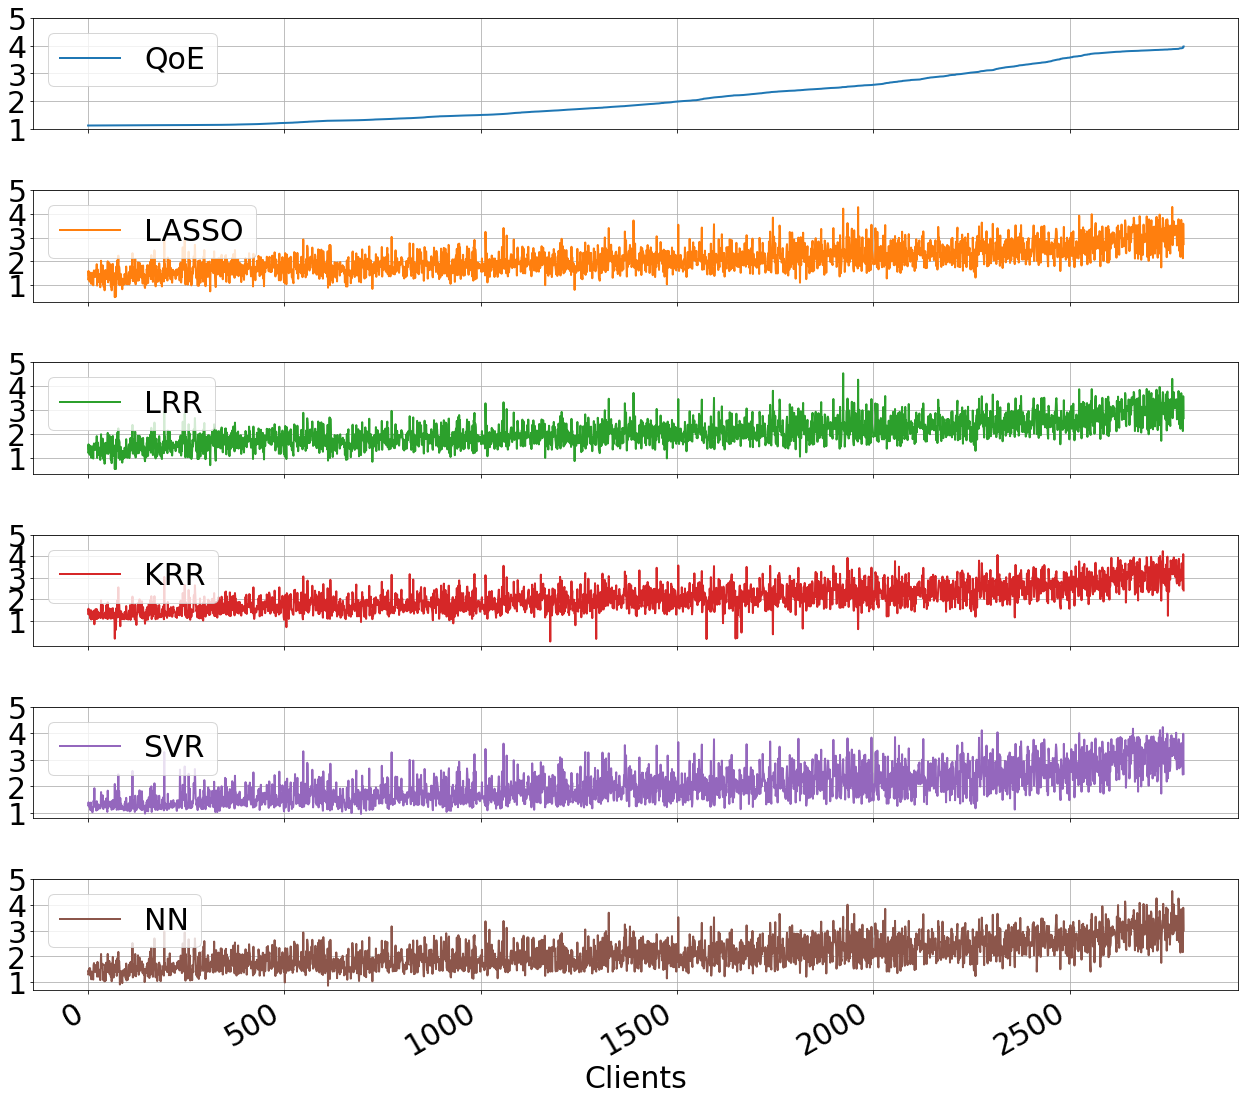

In [40]:
# plt.figure(figsize=(16,8))
# sss.plot(sss,alpha=0.5)
# # sss.plot.area(stacked=False)
# plt.show()

sss.plot(subplots=True, yticks=[1,2,3,4,5],figsize=(18, 16),grid=True)
plt.xlabel('Clients')
plt.tight_layout()
plt.savefig('plot of CMQ QoE vs Predicted QoE by the model with all features in VoD.pdf', dpi=100, bbox_inches='tight')

In [10]:
time1=time.time()
tepre=net(xtest)
testloss=loss_func(tepre,ytest).data.numpy().flatten()[0]
vcpu=psutil.cpu_percent()
print ('Total CPUs utilized percentage :',vcpu,'%')
time2=time.time()
print('the duration of test is:',time2-time1)
print('Percentage of used RAM :',psutil.virtual_memory().percent,'%')

Total CPUs utilized percentage : 14.2 %
the duration of test is: 0.02802896499633789
Percentage of used RAM : 56.1 %


In [11]:
print('training score:',meanloss_train[-1],'validation score:',meanloss_valid[-1])
print('test score:',loss_func(tepre,ytest).data.numpy())

training score: 0.07946626 validation score: 0.11556403
test score: 0.087566406


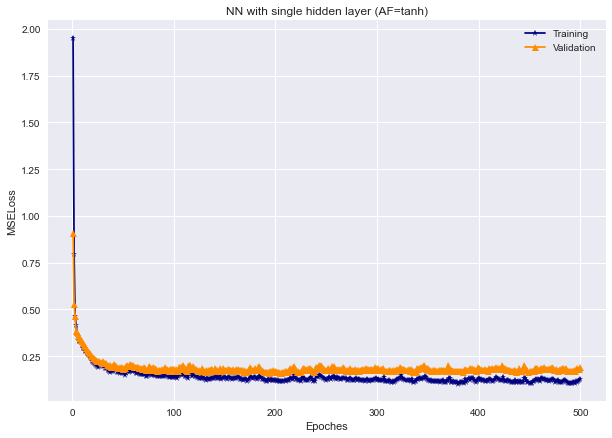

In [9]:
plt.figure(figsize=(10,7))    
plt.style.use('seaborn')
plt.title('NN with single hidden layer (AF=tanh)')
plt.plot(range(1,EPOCH+1),meanloss_train,'*-',label='Training',color='navy')
plt.plot(range(1,EPOCH+1),meanloss_valid,'^-',label='Validation',color='darkorange')
plt.xlabel('Epoches')
plt.ylabel('MSELoss')
plt.legend()
# plt.ylim(0,1)
plt.show() 

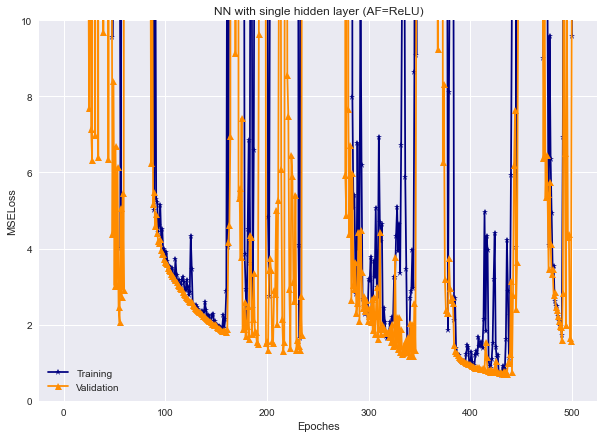

In [63]:
plt.figure(figsize=(10,7))    
plt.style.use('seaborn')
plt.title('NN with single hidden layer (AF=ReLU)')
plt.plot(range(1,EPOCH+1),meanloss_train,'*-',label='Training',color='navy')
plt.plot(range(1,EPOCH+1),meanloss_valid,'^-',label='Validation',color='darkorange')
plt.xlabel('Epoches')
plt.ylabel('MSELoss')
plt.legend()
plt.ylim(0,10)
plt.show() 

## New Version of Parameters Tuning ---Single hidden layer

In [5]:
class RegressorNet(torch.nn.Module):
    def __init__(self, n_feature=10, n_hidden=10, n_output=1):
        super(RegressorNet, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)  # 95-(100-10)-1
        self.predict = torch.nn.Linear(n_hidden, n_output)
    
    def forward(self, x,activefunc):
        if activefunc=='tanh':
            x = torch.tanh(self.hidden1(x))
        elif activefunc=='relu':
            x = torch.relu(self.hidden1(x))
        x = self.predict(x)  # no activation, aka Identity()
        return x

In [6]:
%%time

def tune_NN(epo,batchsize,learningrate,xtrain,ytrain,xtest,ytest,xval,yval,maxnum_feature,activefunc,neurons):
    # Hyper Parameters
    EPOCH = epo              # train the training data 500 times
    BATCH_SIZE = batchsize
    LR = learningrate 

    torch_dataset=Data.TensorDataset(xtrain,ytrain)
    trainloader=Data.DataLoader(dataset=torch_dataset,batch_size=BATCH_SIZE,shuffle=True)

#     start=time.time()
    net=RegressorNet(n_feature=maxnum_feature,n_hidden=300,n_output=1)
    opt=torch.optim.Adam(net.parameters(),lr=LR)
    loss_func=torch.nn.MSELoss()
    meanloss_train=[]
    meanloss_valid=[]

    for epoch in range(EPOCH):
    #     print('Epoch:',epoch)
        step_loss=[]
        for step,(batchx,batchy) in enumerate(trainloader):
            output=net(batchx,activefunc)
            loss=loss_func(output,batchy)
            opt.zero_grad()
            loss.backward()
            opt.step()

            step_loss.append(loss.data.numpy().flatten()[0])
    #     print(step_loss)

        meanloss_train.append(np.array(step_loss).mean())
        valpre=net(xval,activefunc)
        val_loss=loss_func(valpre,yval)
        meanloss_valid.append(val_loss.data.numpy().flatten()[0])
        
    tepre=net(xtest,activefunc)
    return activefunc,epo,batchsize,learningrate,neurons,maxnum_feature*neurons+neurons*1,meanloss_train[-1],meanloss_valid[-1],loss_func(tepre,ytest).data.numpy()
#     print(activefunc,epo,batchsize,learningrate,neurons,'trainS:',meanloss_train[-1],'valS:',meanloss_valid[-1],'testS:',loss_func(tepre,ytest).data.numpy(),'complexity:',(maxnum_feature*neurons+neurons*1))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 6.91 µs


In [7]:
%%time
lr_list=[1e-3,1e-2,1e-1]
epoches_list=[100,200,500,1000]
batchsize_list=[10,20,50,100,200,500,1000]
activation_list=['tanh','relu']
neurons_list=[10,50,200]

i=0
df = pd.DataFrame(columns=['ActiveFunc','Epoches','BatchSize','LR','Neurons','Complexity','TrainScore','ValidScore','TestScore'])
for act in activation_list:
    for bs in batchsize_list:
        for neu in neurons_list:
            for epo in epoches_list:
                for lr in lr_list:
                    i=i+1
                    print(i)
                    activeFunc,epoches,batchSize,lR,neurons,complexity,trainScore,validScore,testScore=tune_NN(epo,bs,lr,xtrain,ytrain,xtest,ytest,xval,yval,maxnum_feature,act,neu)
                    df = df.append({'ActiveFunc':activeFunc,'Epoches':epoches,'BatchSize':batchSize,'LR':lR,'Neurons':neurons,'Complexity':complexity,'TrainScore':trainScore,'ValidScore':validScore,'TestScore':testScore}, ignore_index=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [8]:
df.to_csv('NN_VoD_tuning.csv')

In [19]:
df

,ActiveFunc,Epoches,BatchSize,LR,Neurons,Complexity,TrainScore,ValidScore,TestScore
0,tanh,100,10,0.001,10,970,0.222144,0.240022,0.22845604
1,tanh,100,10,0.010,10,970,0.454535,0.329041,0.32103637
2,tanh,100,10,0.100,10,970,5.019328,0.683932,1.0411141
3,tanh,200,10,0.001,10,970,0.225163,0.224623,0.22312725
4,tanh,200,10,0.010,10,970,0.560736,0.401988,0.39336303
...,...,...,...,...,...,...,...,...,...
499,relu,500,1000,0.010,200,19400,3231.903320,25769.953125,46292.44
500,relu,500,1000,0.100,200,19400,0.451438,0.498960,0.4538246
501,relu,1000,1000,0.001,200,19400,0.999528,2.201023,5.5390778
502,relu,1000,1000,0.010,200,19400,0.178966,0.193357,0.18021746


## Visualization of tuning results¶

In [4]:
df=pd.read_csv('NN_VoD_tuning.csv')

In [5]:
df=df.drop(df.columns[0], axis=1)

In [6]:
lessDF=df[df['TestScore']<=16][['Epoches','BatchSize','LR','Complexity','TrainScore','ValidScore','TestScore']]
lessDF

,Epoches,BatchSize,LR,Complexity,TrainScore,ValidScore,TestScore
0,100,10,0.001,970,0.222144,0.240022,0.228456
1,100,10,0.010,970,0.454535,0.329041,0.321036
2,100,10,0.100,970,5.019328,0.683932,1.041114
3,200,10,0.001,970,0.225163,0.224623,0.223127
4,200,10,0.010,970,0.560736,0.401988,0.393363
...,...,...,...,...,...,...,...
498,500,1000,0.001,19400,0.965201,4.902355,10.110723
500,500,1000,0.100,19400,0.451438,0.498960,0.453825
501,1000,1000,0.001,19400,0.999528,2.201023,5.539078
502,1000,1000,0.010,19400,0.178966,0.193357,0.180217


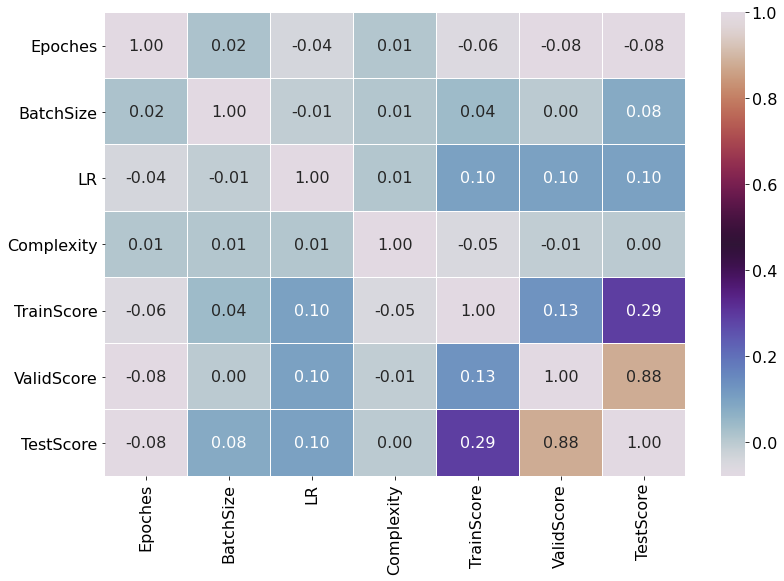

In [9]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(13, 8))
corr = lessDF.corr('pearson')
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="twilight",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
# t= f.suptitle('Attributes spearman Correlation Heatmap of NN tuning in VoD Dataset', fontsize=20)
plt.savefig('Attributes Pearson Correlation Heatmap of NN tuning in VoD Dataset(Test score<=16).pdf',dpi=100, bbox_inches='tight')

## Parameters Tuning ---Single hidden layer

### with Loop (Different Learning rate and epoches)

In [5]:
'''
Build the network method 1
'''
class RegressorNet(torch.nn.Module):
    def __init__(self, n_feature=10, n_hidden=10, n_output=1):
        super(RegressorNet, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)  # 95-(100-10)-1
        self.predict = torch.nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.predict(x)  # no activation, aka Identity()
        return x

In [10]:
'''
Build the network method 2 快速搭建法
与method1 的效果功能相同
'''
net1=RegressorNet(2,10,2)
print(net1)

net2=torch.nn.Sequential(
    torch.nn.Linear(2,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,2),
)

print(net2)

RegressorNet(
  (hidden1): Linear(in_features=2, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=2, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
)


In [15]:
def netTraining(n_feature,n_hidden,lr,epoches,xtrain,xtest,ytrain,ytest):

    net=RegressorNet(n_feature=n_feature, n_hidden=n_hidden, n_output=1)

    # net=Net(n_feature=maxnum_feature, n_hidden=100, n_output=1)
    # associate to all parameters in network and learning rate is 0.1
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
#     loss_func = torch.nn.MSELoss()  #apply Mean squared error to regression problem
    loss_func=torch.nn.L1Loss() # mean absolute error (MAE) between each element in the input x and target y .
    
    for i in range(epoches):
        prediction=net(xtrain)
        loss=loss_func(prediction,ytrain) 
        print('this is loss',loss)

        #optimizing
        optimizer.zero_grad() # clear the gradient for the next training
        loss.backward() # back propogation for calculating the gradient of each parameter
        optimizer.step() # update weights and biases
        print(loss.data.numpy())
    tepre=net(xtest)
    testloss=loss_func(tepre,ytest).data.numpy().flatten()[0]
    
    return testloss

In [16]:
netTraining(maxnum_feature,300,0.01,10,xtrain,xtest,ytrain,ytest)

this is loss tensor(270.2265, grad_fn=<L1LossBackward>)
270.22653
this is loss tensor(685.1254, grad_fn=<L1LossBackward>)
685.12537
this is loss tensor(585.9053, grad_fn=<L1LossBackward>)
585.90533
this is loss tensor(253.5840, grad_fn=<L1LossBackward>)
253.58395
this is loss tensor(239.5107, grad_fn=<L1LossBackward>)
239.5107
this is loss tensor(357.5493, grad_fn=<L1LossBackward>)
357.54932
this is loss tensor(292.7122, grad_fn=<L1LossBackward>)
292.71216
this is loss tensor(119.6873, grad_fn=<L1LossBackward>)
119.68734
this is loss tensor(119.0798, grad_fn=<L1LossBackward>)
119.07978
this is loss tensor(213.5163, grad_fn=<L1LossBackward>)
213.51625


269.4014

In [40]:
%%time
'''
Training the network
'''
def netTraining(n_feature,n_hidden,lr,epoches,xtrain,xtest,ytrain,ytest):

    net=RegressorNet(n_feature=n_feature, n_hidden=n_hidden, n_output=1)

    # net=Net(n_feature=maxnum_feature, n_hidden=100, n_output=1)
    # associate to all parameters in network and learning rate is 0.1
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
#     loss_func = torch.nn.MSELoss()  #apply Mean squared error to regression problem
    loss_func=torch.nn.L1Loss() # mean absolute error (MAE) between each element in the input x and target y .
    
    for i in range(epoches):
        prediction=net(xtrain)
        loss=loss_func(prediction,ytrain) 

        #optimizing
        optimizer.zero_grad() # clear the gradient for the next training
        loss.backward() # back propogation for calculating the gradient of each parameter
        optimizer.step() # update weights and biases
    
    tepre=net(xtest)
    testloss=loss_func(tepre,ytest).data.numpy().flatten()[0]
    
    return testloss
    

lr_list=[1e-1,0.01,0.007,0.005,0.003,0.001,1e-4,1e-5]
ep_list=[100,300,500,700,1000]
#results
rs_lr=[]
rs_ep=[]

print('-------MSE--------')
for lr in lr_list:
#     rs_lr.append(netTraining(maxnum_feature,300,lr,500,xtrain,xtest,ytrain,ytest))
    print(netTraining(maxnum_feature,300,lr,500,xtrain,xtest,ytrain,ytest))
# plt.figure(figsize=(10,7))    
# plt.style.use('seaborn')
# plt.title('NN with single hidden layer')
# plt.plot(lr_list,rs_lr,'*-')
# plt.xlabel('Learning Rate')
# plt.ylabel('MSE')
# plt.show()

for ep in ep_list:
#     rs_ep.append(netTraining(maxnum_feature,300,0.001,ep,xtrain,xtest,ytrain,ytest))
    print(netTraining(maxnum_feature,300,0.001,ep,xtrain,xtest,ytrain,ytest))
# plt.figure(figsize=(10,7))    
# plt.style.use('seaborn')
# plt.title('NN with single hidden layer')
# plt.plot(ep_list,rs_ep,'*-')
# plt.xlabel('Epoches')
# plt.ylabel('MSE')
# plt.show()      

# print(rs_lr)
# print(rs_ep)


-------MSE--------
0.46440908
0.32387933
2.0852122
6.2009234
23.620941
6.027427
0.6539311
1.1837518
15.375856
28.34609
3.8250902
9.047315
2.5642521
CPU times: user 11min 11s, sys: 41.6 s, total: 11min 52s
Wall time: 4min 19s


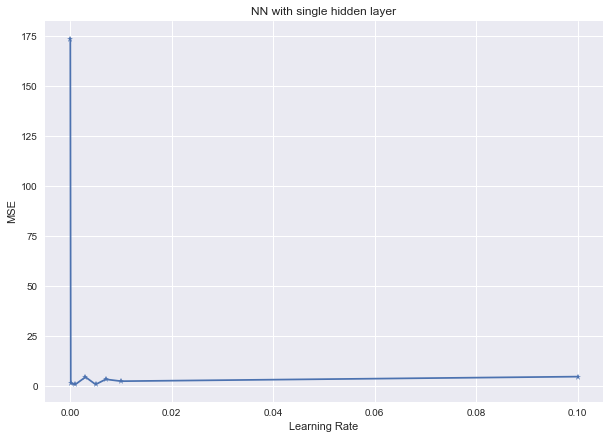

In [38]:
plt.figure(figsize=(10,7))    
plt.style.use('seaborn')
plt.title('NN with single hidden layer')
plt.plot(lr_list,rs_lr,'*-')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.show()


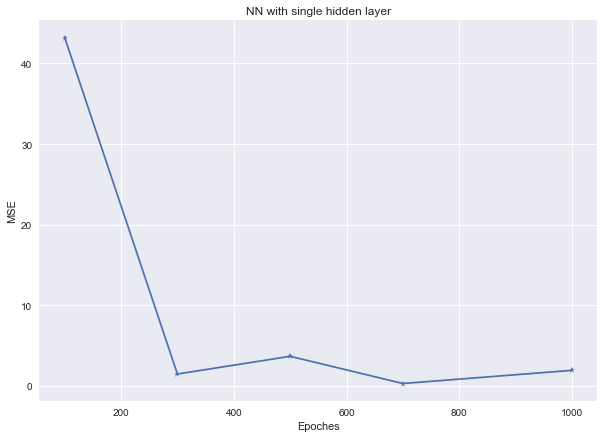

In [39]:
plt.figure(figsize=(10,7))    
plt.style.use('seaborn')
plt.title('NN with single hidden layer')
plt.plot(ep_list,rs_ep,'*-')
plt.xlabel('Epoches')
plt.ylabel('MSE')
plt.show() 

### with Loop (Different complexity)

In [14]:
'''
Build the network
'''
class RegressorNet(torch.nn.Module):
    def __init__(self, n_feature=10, n_hidden=10, n_output=1):
        super(RegressorNet, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)  # 95-(100-10)-1
        self.predict = torch.nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.predict(x)  # no activation, aka Identity()
        return x

In [17]:
%%time
'''
Training the network
'''
def netTraining(n_feature,n_hidden,lr,epoches,xtrain,xtest,ytrain,ytest):

    net=RegressorNet(n_feature=n_feature, n_hidden=n_hidden, n_output=1)

    # net=Net(n_feature=maxnum_feature, n_hidden=100, n_output=1)
    # associate to all parameters in network and learning rate is 0.1
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
#     loss_func = torch.nn.MSELoss()  #apply Mean squared error to regression problem
    loss_func=torch.nn.L1Loss() # mean absolute error (MAE) between each element in the input x and target y .
    
    for i in range(epoches):
        prediction=net(xtrain)
        loss=loss_func(prediction,ytrain)

        #optimizing
        optimizer.zero_grad() # clear the gradient for the next training
        loss.backward() # back propogation for calculating the gradient of each parameter
        optimizer.step() # update weights and biases
    
    tepre=net(xtest)
    testloss=loss_func(tepre,ytest).data.numpy().flatten()[0]
    
    return testloss
    

neurons_list=[50,100,200,300,500,700,1000,1300]
#results
rs_neurons=[]
complexity=[]


print('-------MSE--------')
for n in neurons_list:
    tmp=netTraining(maxnum_feature,n,0.001,700,xtrain,xtest,ytrain,ytest)
    rs_neurons.append(tmp)
    complexity.append(maxnum_feature*n+n*1)
    print(tmp)


-------MSE--------
1.0044681
2.8793008
4.750298
13.246732
17.692114
10.659785
22.395092
40.77736
CPU times: user 15min 57s, sys: 51.7 s, total: 16min 49s
Wall time: 5min 47s


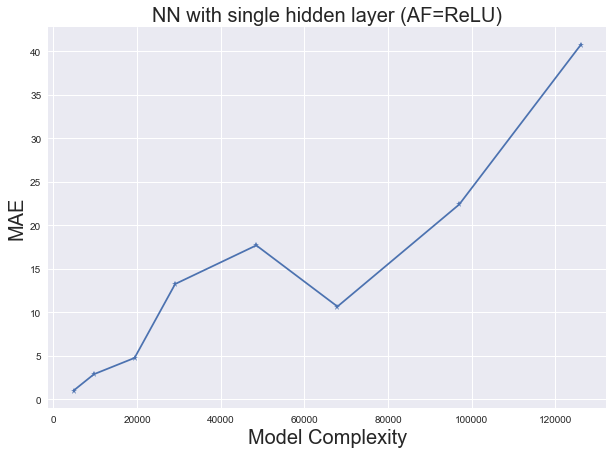

In [18]:
plt.figure(figsize=(10,7))    
plt.style.use('seaborn')
plt.title('NN with single hidden layer (AF=ReLU)',fontsize=20)
plt.plot(complexity,rs_neurons,'*-')
plt.xlabel('Model Complexity',fontsize=20)
plt.ylabel('MAE',fontsize=20)
plt.show() 

### with GridSearchCV

In [28]:
'''
Build the network
'''
class RegressorNet(torch.nn.Module):
    def __init__(self, n_feature=10, n_hidden=10, n_output=1):
        super(RegressorNet, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)  # 95-(100-10)-1
        self.predict = torch.nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.predict(x)  # no activation, aka Identity()
        return x

In [29]:
net=NeuralNetRegressor(RegressorNet,
                       max_epochs=1000,
                       lr=0.001,
                       verbose=1,
                       # Shuffle training data on each epoch
                       iterator_train__shuffle=True,
                      )

In [30]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),])

In [32]:
params = [{
    'net__lr': [0.01, 0.02],
    'net__max_epochs': [100, 200],
    'module__n_feature': [maxnum_feature],
    'module__n_hidden': [100,200],
    
}]
gs = GridSearchCV(pipe, params, refit=False, cv=5, scoring='r2')

In [33]:
gs.fit(xtrain,ytrain)

ValueError: Invalid parameter module for estimator Pipeline(steps=[('scale', StandardScaler()),
                ('net',
                 <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.RegressorNet'>,
))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        '''
        A feedForward neural network.
        Argurmets:
            n_feature: How many of features in your data
            n_hidden:  How many of neurons in the hidden layer
            n_output:  How many of neuros in the output leyar (defaut=1)
        '''
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(maxnum_feature, 100, bias=True)   # hidden layer
        self.predict = torch.nn.Linear(100, 1, bias=True)   # output layer
#         self.n_feature, self.n_hidden, self.n_output = D_in, H, D_out
    def forward(self, x,**kwargs):
        '''
        Argurmets:
            x: Features to predict
        '''
        torch.nn.init.constant_(self.hidden.bias.data,1)
        torch.nn.init.constant_(self.predict.bias.data,1)
        x = torch.sigmoid(self.hidden(x))      # activation function for hidden layer
        x = torch.sigmoid(self.predict(x))     # linear output
        return x

In [6]:
net = NeuralNetRegressor(Net
                         , max_epochs=100
                         , lr=0.001
                         , verbose=1)

In [ ]:
%%time
params = {
    'lr': [0.001,0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    'max_epochs': list(range(500,5500, 500))
}

gs = GridSearchCV(net, params, refit=False, scoring='r2', verbose=1, cv=5)

gs.fit(xtrain,ytrain)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.6036        2.5670  0.2809
      2        2.4227        2.4666  0.2535
      3        2.3546        2.4190  0.2464
      4        2.3190        2.3916  0.2378
      5        2.2972        2.3737  0.2333
      6        2.2824        2.3611  0.2425
      7        2.2717        2.3517  0.2339
      8        2.2637        2.3446  0.2478
      9        2.2574        2.3390  0.2417
     10        2.2524        2.3344  0.2278
     11        2.2483        2.3306  0.2334
     12        2.2449        2.3275  0.2388
     13        2.2420        2.3247  0.2518
     14        2.2395        2.3224  0.2288
     15        2.2374        2.3204  0.2389
     16        2.2355        2.3186  0.2366
     17        2.2339        2.3170  0.2533
     18        2.2324        2.3156  0.2369
     19        2.2311        2.3143  0.2309
     20        2.2299        2.3131  0.2423
     21        2.2288        2.3

    132        2.2110        2.2945  0.2404
    133        2.2109        2.2945  0.2228
    134        2.2109        2.2944  0.2290
    135        2.2109        2.2944  0.2265
    136        2.2109        2.2944  0.2400
    137        2.2109        2.2944  0.2288
    138        2.2108        2.2943  0.2286
    139        2.2108        2.2943  0.2255
    140        2.2108        2.2943  0.2220
    141        2.2108        2.2943  0.2310
    142        2.2108        2.2943  0.2313
    143        2.2107        2.2942  0.2298
    144        2.2107        2.2942  0.2335
    145        2.2107        2.2942  0.2306
    146        2.2107        2.2942  0.2311
    147        2.2107        2.2942  0.2289
    148        2.2106        2.2942  0.2241
    149        2.2106        2.2941  0.2266
    150        2.2106        2.2941  0.2412
    151        2.2106        2.2941  0.2273
    152        2.2106        2.2941  0.2251
    153        2.2106        2.2941  0.2404
    154        2.2105        2.2

    265        2.2094        2.2930  0.2398
    266        2.2094        2.2929  0.2446
    267        2.2094        2.2929  0.2262
    268        2.2094        2.2929  0.2291
    269        2.2094        2.2929  0.2424
    270        2.2094        2.2929  0.2370
    271        2.2094        2.2929  0.2313
    272        2.2094        2.2929  0.2333
    273        2.2094        2.2929  0.2424
    274        2.2094        2.2929  0.2320
    275        2.2094        2.2929  0.2292
    276        2.2094        2.2929  0.2248
    277        2.2094        2.2929  0.2274
    278        2.2094        2.2929  0.2270
    279        2.2094        2.2929  0.2435
    280        2.2094        2.2929  0.2439
    281        2.2094        2.2929  0.2274
    282        2.2094        2.2929  0.2287
    283        2.2093        2.2929  0.2213
    284        2.2093        2.2929  0.2271
    285        2.2093        2.2929  0.2383
    286        2.2093        2.2928  0.2467
    287        2.2093        2.2

    398        2.2089        2.2924  0.2360
    399        2.2089        2.2924  0.2361
    400        2.2089        2.2924  0.2217
    401        2.2089        2.2924  0.2324
    402        2.2089        2.2924  0.2283
    403        2.2089        2.2924  0.2213
    404        2.2089        2.2924  0.2177
    405        2.2089        2.2924  0.2212
    406        2.2089        2.2924  0.2353
    407        2.2089        2.2924  0.2309
    408        2.2089        2.2924  0.2317
    409        2.2089        2.2924  0.2239
    410        2.2089        2.2924  0.2358
    411        2.2089        2.2924  0.2260
    412        2.2089        2.2924  0.2397
    413        2.2089        2.2924  0.2284
    414        2.2089        2.2924  0.2351
    415        2.2089        2.2924  0.2428
    416        2.2089        2.2924  0.2333
    417        2.2089        2.2924  0.2407
    418        2.2089        2.2924  0.2407
    419        2.2089        2.2924  0.2350
    420        2.2089        2.2

     29        2.2176        2.1846  0.2285
     30        2.2171        2.1842  0.2224
     31        2.2167        2.1838  0.2178
     32        2.2163        2.1834  0.2284
     33        2.2160        2.1831  0.2297
     34        2.2156        2.1827  0.2338
     35        2.2153        2.1824  0.2365
     36        2.2150        2.1822  0.2151
     37        2.2148        2.1819  0.2263
     38        2.2145        2.1816  0.2285
     39        2.2142        2.1814  0.2187
     40        2.2140        2.1812  0.2260
     41        2.2138        2.1809  0.2402
     42        2.2136        2.1807  0.2207
     43        2.2134        2.1805  0.2229
     44        2.2132        2.1804  0.2361
     45        2.2130        2.1802  0.2315
     46        2.2128        2.1800  0.2238
     47        2.2126        2.1798  0.2303
     48        2.2125        2.1797  0.2219
     49        2.2123        2.1795  0.2261
     50        2.2121        2.1794  0.2289
     51        2.2120        2.1

    162        2.2069        2.1743  0.2408
    163        2.2069        2.1743  0.2372
    164        2.2069        2.1743  0.2283
    165        2.2069        2.1742  0.2222
    166        2.2068        2.1742  0.2280
    167        2.2068        2.1742  0.2289
    168        2.2068        2.1742  0.2073
    169        2.2068        2.1742  0.2196
    170        2.2068        2.1742  0.2440
    171        2.2068        2.1742  0.2275
    172        2.2068        2.1741  0.2329
    173        2.2067        2.1741  0.2323
    174        2.2067        2.1741  0.2377
    175        2.2067        2.1741  0.2378
    176        2.2067        2.1741  0.2357
    177        2.2067        2.1741  0.2412
    178        2.2067        2.1741  0.2358
    179        2.2067        2.1740  0.2419
    180        2.2066        2.1740  0.2361
    181        2.2066        2.1740  0.2269
    182        2.2066        2.1740  0.2309
    183        2.2066        2.1740  0.2318
    184        2.2066        2.1

    295        2.2059        2.1733  0.2447
    296        2.2059        2.1733  0.2271
    297        2.2059        2.1732  0.2234
    298        2.2059        2.1732  0.2338
    299        2.2058        2.1732  0.2291
    300        2.2058        2.1732  0.2364
    301        2.2058        2.1732  0.2311
    302        2.2058        2.1732  0.2266
    303        2.2058        2.1732  0.2273
    304        2.2058        2.1732  0.2301
    305        2.2058        2.1732  0.2376
    306        2.2058        2.1732  0.2258
    307        2.2058        2.1732  0.2304
    308        2.2058        2.1732  0.2386
    309        2.2058        2.1732  0.2362
    310        2.2058        2.1732  0.2315
    311        2.2058        2.1732  0.2567
    312        2.2058        2.1732  0.2332
    313        2.2058        2.1732  0.2317
    314        2.2058        2.1732  0.2377
    315        2.2058        2.1732  0.2294
    316        2.2058        2.1732  0.2440
    317        2.2058        2.1

    428        2.2055        2.1729  0.2350
    429        2.2055        2.1729  0.2369
    430        2.2055        2.1729  0.2245
    431        2.2055        2.1729  0.2380
    432        2.2055        2.1729  0.2449
    433        2.2055        2.1729  0.2314
    434        2.2055        2.1729  0.2332
    435        2.2055        2.1729  0.2293
    436        2.2055        2.1729  0.2280
    437        2.2055        2.1729  0.2250
    438        2.2055        2.1729  0.2251
    439        2.2055        2.1729  0.2177
    440        2.2055        2.1729  0.2457
    441        2.2055        2.1729  0.2311
    442        2.2055        2.1729  0.2389
    443        2.2055        2.1729  0.2367
    444        2.2055        2.1729  0.2311
    445        2.2055        2.1729  0.2382
    446        2.2055        2.1729  0.2327
    447        2.2055        2.1729  0.2292
    448        2.2055        2.1729  0.2249
    449        2.2055        2.1729  0.2290
    450        2.2055        2.1

     59        2.2598        2.1793  0.2354
     60        2.2596        2.1792  0.2368
     61        2.2595        2.1791  0.2245
     62        2.2594        2.1790  0.2325
     63        2.2593        2.1789  0.2392
     64        2.2592        2.1788  0.2326
     65        2.2591        2.1786  0.2377
     66        2.2590        2.1785  0.2291
     67        2.2589        2.1784  0.2304
     68        2.2588        2.1784  0.2378
     69        2.2587        2.1783  0.2440
     70        2.2586        2.1782  0.2277
     71        2.2585        2.1781  0.2410
     72        2.2584        2.1780  0.2222
     73        2.2583        2.1779  0.2326
     74        2.2582        2.1778  0.2416
     75        2.2582        2.1778  0.2415
     76        2.2581        2.1777  0.2335
     77        2.2580        2.1776  0.2422
     78        2.2579        2.1775  0.2343
     79        2.2578        2.1774  0.2262
     80        2.2577        2.1773  0.2398
     81        2.2577        2.1

    192        2.2545        2.1742  0.2320
    193        2.2545        2.1742  0.2354
    194        2.2545        2.1742  0.2357
    195        2.2545        2.1742  0.2422
    196        2.2545        2.1742  0.2287
    197        2.2545        2.1741  0.2439
    198        2.2545        2.1741  0.2366
    199        2.2544        2.1741  0.2198
    200        2.2544        2.1741  0.2352
    201        2.2544        2.1741  0.2110
    202        2.2544        2.1741  0.2277
    203        2.2544        2.1740  0.2339
    204        2.2543        2.1740  0.2329
    205        2.2543        2.1740  0.2375
    206        2.2543        2.1740  0.2145
    207        2.2543        2.1740  0.2401
    208        2.2543        2.1740  0.2321
    209        2.2543        2.1740  0.2369
    210        2.2543        2.1739  0.2365
    211        2.2542        2.1739  0.2378
    212        2.2542        2.1739  0.2337
    213        2.2542        2.1739  0.2394
    214        2.2542        2.1

    325        2.2536        2.1733  0.2311
    326        2.2536        2.1733  0.2307
    327        2.2536        2.1733  0.2311
    328        2.2536        2.1733  0.2358
    329        2.2536        2.1733  0.2364
    330        2.2536        2.1733  0.2242
    331        2.2536        2.1733  0.2328
    332        2.2536        2.1733  0.2302
    333        2.2536        2.1733  0.2435
    334        2.2535        2.1733  0.2289
    335        2.2535        2.1733  0.2306
    336        2.2535        2.1733  0.2275
    337        2.2535        2.1733  0.2330
    338        2.2535        2.1732  0.2226
    339        2.2535        2.1732  0.2348
    340        2.2535        2.1732  0.2390
    341        2.2535        2.1732  0.2238
    342        2.2535        2.1732  0.2324
    343        2.2535        2.1732  0.2227
    344        2.2535        2.1732  0.2415
    345        2.2535        2.1732  0.2379
    346        2.2535        2.1732  0.2215
    347        2.2535        2.1

    458        2.2532        2.1730  0.3354
    459        2.2532        2.1729  0.2731
    460        2.2532        2.1729  0.2941
    461        2.2532        2.1729  0.2848
    462        2.2532        2.1729  0.2660
    463        2.2532        2.1729  0.3012
    464        2.2532        2.1729  0.2732
    465        2.2532        2.1729  0.2659
    466        2.2532        2.1729  0.2553
    467        2.2532        2.1729  0.2360
    468        2.2532        2.1729  0.2232
    469        2.2532        2.1729  0.2346
    470        2.2532        2.1729  0.2309
    471        2.2532        2.1729  0.2369
    472        2.2532        2.1729  0.2299
    473        2.2532        2.1729  0.2467
    474        2.2532        2.1729  0.2341
    475        2.2532        2.1729  0.2375
    476        2.2532        2.1729  0.2189
    477        2.2532        2.1729  0.2407
    478        2.2532        2.1729  0.2275
    479        2.2532        2.1729  0.2305
    480        2.2532        2.1

     89        2.2403        2.1766  0.2485
     90        2.2402        2.1766  0.2413
     91        2.2402        2.1765  0.2467
     92        2.2401        2.1765  0.2482
     93        2.2401        2.1764  0.2334
     94        2.2400        2.1764  0.2400
     95        2.2400        2.1764  0.2347
     96        2.2399        2.1763  0.2175
     97        2.2399        2.1763  0.2374
     98        2.2399        2.1762  0.2463
     99        2.2398        2.1762  0.2323
    100        2.2398        2.1761  0.2300
    101        2.2397        2.1761  0.2260
    102        2.2397        2.1760  0.2411
    103        2.2396        2.1760  0.2321
    104        2.2396        2.1760  0.2340
    105        2.2396        2.1759  0.2296
    106        2.2395        2.1759  0.2357
    107        2.2395        2.1759  0.2333
    108        2.2395        2.1758  0.2374
    109        2.2394        2.1758  0.2326
    110        2.2394        2.1758  0.2260
    111        2.2393        2.1

    222        2.2375        2.1739  0.2346
    223        2.2374        2.1739  0.2152
    224        2.2374        2.1738  0.2357
    225        2.2374        2.1738  0.2355
    226        2.2374        2.1738  0.2369
    227        2.2374        2.1738  0.2334
    228        2.2374        2.1738  0.2314
    229        2.2374        2.1738  0.2323
    230        2.2374        2.1738  0.2342
    231        2.2374        2.1738  0.2309
    232        2.2374        2.1738  0.2326
    233        2.2374        2.1738  0.2340
    234        2.2374        2.1738  0.2359
    235        2.2373        2.1738  0.2351
    236        2.2373        2.1738  0.2135
    237        2.2373        2.1737  0.2277
    238        2.2373        2.1737  0.2210
    239        2.2373        2.1737  0.2366
    240        2.2373        2.1737  0.2376
    241        2.2373        2.1737  0.2327
    242        2.2373        2.1737  0.2333
    243        2.2373        2.1737  0.2220
    244        2.2373        2.1

    355        2.2367        2.1732  0.2397
    356        2.2367        2.1732  0.2410
    357        2.2367        2.1731  0.2163
    358        2.2367        2.1731  0.2433
    359        2.2367        2.1731  0.2296
    360        2.2367        2.1731  0.2347
    361        2.2367        2.1731  0.2285
    362        2.2367        2.1731  0.2345
    363        2.2367        2.1731  0.2530
    364        2.2367        2.1731  0.2294
    365        2.2367        2.1731  0.2564
    366        2.2367        2.1731  0.2231
    367        2.2367        2.1731  0.2370
    368        2.2367        2.1731  0.2226
    369        2.2367        2.1731  0.2250
    370        2.2367        2.1731  0.2262
    371        2.2367        2.1731  0.2255
    372        2.2367        2.1731  0.2367
    373        2.2367        2.1731  0.2380
    374        2.2367        2.1731  0.2411
    375        2.2367        2.1731  0.2317
    376        2.2367        2.1731  0.2440
    377        2.2367        2.1

    488        2.2364        2.1729  0.2328
    489        2.2364        2.1729  0.2374
    490        2.2364        2.1729  0.2572
    491        2.2364        2.1729  0.2297
    492        2.2364        2.1729  0.2180
    493        2.2364        2.1729  0.2350
    494        2.2364        2.1729  0.2330
    495        2.2364        2.1729  0.2368
    496        2.2364        2.1729  0.2383
    497        2.2364        2.1729  0.2362
    498        2.2364        2.1728  0.2292
    499        2.2364        2.1728  0.2374
    500        2.2364        2.1728  0.2434
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.6781        2.4515  0.2277
      2        2.4530        2.3417  0.2344
      3        2.3783        2.2928  0.2434
      4        2.3408        2.2650  0.2204
      5        2.3182        2.2473  0.2257
      6        2.3034        2.2352  0.2227
      7        2.2927        2.2261  0.2276
      8        2.2847        2.2

    119        2.2365        2.1751  0.2251
    120        2.2365        2.1751  0.2481
    121        2.2365        2.1750  0.2395
    122        2.2364        2.1750  0.2336
    123        2.2364        2.1750  0.2397
    124        2.2364        2.1750  0.2393
    125        2.2364        2.1749  0.2405
    126        2.2363        2.1749  0.2300
    127        2.2363        2.1749  0.2560
    128        2.2363        2.1749  0.2319
    129        2.2363        2.1749  0.2317
    130        2.2362        2.1748  0.2565
    131        2.2362        2.1748  0.2270
    132        2.2362        2.1748  0.2377
    133        2.2362        2.1748  0.2452
    134        2.2362        2.1748  0.2285
    135        2.2361        2.1747  0.2311
    136        2.2361        2.1747  0.2386
    137        2.2361        2.1747  0.2325
    138        2.2361        2.1747  0.2434
    139        2.2361        2.1747  0.2254
    140        2.2360        2.1746  0.2309
    141        2.2360        2.1

    252        2.2349        2.1735  0.2406
    253        2.2348        2.1735  0.2429
    254        2.2348        2.1734  0.2334
    255        2.2348        2.1734  0.2368
    256        2.2348        2.1734  0.2439
    257        2.2348        2.1734  0.2328
    258        2.2348        2.1734  0.2252
    259        2.2348        2.1734  0.2495
    260        2.2348        2.1734  0.2350
    261        2.2348        2.1734  0.2431
    262        2.2348        2.1734  0.2293
    263        2.2348        2.1734  0.2515
    264        2.2348        2.1734  0.2375
    265        2.2348        2.1734  0.2256
    266        2.2348        2.1734  0.2263
    267        2.2348        2.1734  0.2402
    268        2.2348        2.1734  0.2402
    269        2.2347        2.1734  0.2215
    270        2.2347        2.1734  0.2434
    271        2.2347        2.1734  0.2431
    272        2.2347        2.1733  0.2561
    273        2.2347        2.1733  0.2342
    274        2.2347        2.1

    385        2.2344        2.1730  0.2411
    386        2.2344        2.1730  0.2249
    387        2.2344        2.1730  0.2284
    388        2.2344        2.1730  0.2303
    389        2.2344        2.1730  0.2330
    390        2.2343        2.1730  0.2359
    391        2.2343        2.1730  0.2454
    392        2.2343        2.1730  0.2311
    393        2.2343        2.1730  0.2522
    394        2.2343        2.1730  0.2218
    395        2.2343        2.1730  0.2381
    396        2.2343        2.1730  0.2327
    397        2.2343        2.1730  0.2335
    398        2.2343        2.1730  0.2461
    399        2.2343        2.1730  0.2367
    400        2.2343        2.1730  0.2383
    401        2.2343        2.1729  0.2229
    402        2.2343        2.1729  0.2294
    403        2.2343        2.1729  0.2261
    404        2.2343        2.1729  0.2344
    405        2.2343        2.1729  0.2575
    406        2.2343        2.1729  0.2486
    407        2.2343        2.1

     16        2.2354        2.3184  0.2509
     17        2.2336        2.3167  0.2309
     18        2.2320        2.3151  0.2390
     19        2.2305        2.3136  0.2251
     20        2.2291        2.3122  0.2142
     21        2.2276        2.3108  0.2178
     22        2.2265        2.3099  0.2411
     23        2.2256        2.3090  0.2427
     24        2.2249        2.3083  0.2296
     25        2.2242        2.3076  0.2315
     26        2.2236        2.3070  0.2218
     27        2.2230        2.3064  0.2304
     28        2.2224        2.3059  0.2299
     29        2.2219        2.3054  0.2469
     30        2.2215        2.3050  0.2278
     31        2.2210        2.3045  0.2429
     32        2.2206        2.3041  0.2456
     33        2.2202        2.3038  0.2401
     34        2.2199        2.3034  0.2283
     35        2.2195        2.3031  0.2360
     36        2.2192        2.3028  0.2352
     37        2.2189        2.3025  0.2327
     38        2.2186        2.3

    149        2.2107        2.2942  0.2373
    150        2.2107        2.2942  0.2426
    151        2.2107        2.2942  0.2341
    152        2.2106        2.2942  0.2455
    153        2.2106        2.2941  0.2449
    154        2.2106        2.2941  0.2411
    155        2.2106        2.2941  0.2358
    156        2.2106        2.2941  0.2374
    157        2.2106        2.2941  0.2231
    158        2.2105        2.2941  0.2306
    159        2.2105        2.2940  0.2257
    160        2.2105        2.2940  0.2339
    161        2.2105        2.2940  0.2253
    162        2.2105        2.2940  0.2296
    163        2.2105        2.2940  0.2400
    164        2.2104        2.2940  0.2261
    165        2.2104        2.2939  0.2518
    166        2.2104        2.2939  0.2500
    167        2.2104        2.2939  0.2285
    168        2.2104        2.2939  0.2458
    169        2.2104        2.2939  0.2466
    170        2.2103        2.2939  0.2257
    171        2.2103        2.2

    282        2.2094        2.2929  0.3018
    283        2.2094        2.2929  0.2555
    284        2.2094        2.2929  0.2589
    285        2.2094        2.2929  0.2753
    286        2.2094        2.2929  0.3261
    287        2.2094        2.2929  0.3754
    288        2.2094        2.2929  0.2249
    289        2.2094        2.2929  0.2288
    290        2.2094        2.2929  0.2344
    291        2.2094        2.2929  0.2384
    292        2.2094        2.2929  0.2370
    293        2.2094        2.2929  0.2227
    294        2.2094        2.2929  0.2354
    295        2.2094        2.2929  0.2379
    296        2.2094        2.2929  0.2401
    297        2.2094        2.2929  0.2277
    298        2.2093        2.2929  0.2449
    299        2.2093        2.2929  0.2499
    300        2.2093        2.2929  0.2350
    301        2.2093        2.2928  0.2430
    302        2.2093        2.2928  0.2230
    303        2.2093        2.2928  0.2263
    304        2.2093        2.2

    415        2.2090        2.2925  0.2397
    416        2.2090        2.2925  0.2400
    417        2.2090        2.2925  0.2298
    418        2.2090        2.2925  0.2260
    419        2.2090        2.2925  0.2297
    420        2.2090        2.2925  0.2247
    421        2.2090        2.2925  0.2452
    422        2.2090        2.2925  0.2447
    423        2.2090        2.2925  0.2433
    424        2.2090        2.2925  0.2332
    425        2.2089        2.2925  0.2318
    426        2.2089        2.2925  0.2284
    427        2.2089        2.2925  0.2394
    428        2.2089        2.2924  0.2327
    429        2.2089        2.2924  0.2353
    430        2.2089        2.2924  0.2288
    431        2.2089        2.2924  0.2364
    432        2.2089        2.2924  0.2466
    433        2.2089        2.2924  0.2363
    434        2.2089        2.2924  0.2456
    435        2.2089        2.2924  0.2239
    436        2.2089        2.2924  0.2262
    437        2.2089        2.2

    548        2.2087        2.2922  0.2407
    549        2.2087        2.2922  0.2436
    550        2.2087        2.2922  0.2324
    551        2.2087        2.2922  0.2286
    552        2.2087        2.2922  0.2271
    553        2.2087        2.2922  0.2336
    554        2.2087        2.2922  0.2427
    555        2.2087        2.2922  0.2241
    556        2.2087        2.2922  0.2206
    557        2.2087        2.2922  0.2228
    558        2.2087        2.2922  0.2379
    559        2.2087        2.2922  0.2334
    560        2.2087        2.2922  0.2371
    561        2.2087        2.2922  0.2381
    562        2.2087        2.2922  0.2359
    563        2.2087        2.2922  0.2429
    564        2.2087        2.2922  0.2199
    565        2.2087        2.2922  0.2456
    566        2.2087        2.2922  0.2427
    567        2.2087        2.2922  0.2360
    568        2.2087        2.2922  0.2417
    569        2.2087        2.2922  0.2402
    570        2.2087        2.2

    681        2.2086        2.2921  0.2325
    682        2.2086        2.2921  0.2435
    683        2.2086        2.2921  0.2329
    684        2.2086        2.2921  0.2346
    685        2.2086        2.2921  0.2443
    686        2.2086        2.2921  0.2376
    687        2.2086        2.2921  0.2415
    688        2.2086        2.2921  0.2385
    689        2.2086        2.2921  0.2363
    690        2.2086        2.2921  0.2445
    691        2.2086        2.2921  0.2479
    692        2.2086        2.2921  0.2490
    693        2.2086        2.2921  0.2346
    694        2.2086        2.2921  0.2322
    695        2.2086        2.2921  0.2394
    696        2.2086        2.2921  0.2386
    697        2.2086        2.2921  0.2461
    698        2.2086        2.2921  0.2399
    699        2.2086        2.2921  0.2457
    700        2.2086        2.2921  0.2631
    701        2.2086        2.2921  0.2426
    702        2.2086        2.2921  0.2301
    703        2.2086        2.2

    814        2.2085        2.2920  0.2355
    815        2.2085        2.2920  0.2396
    816        2.2085        2.2920  0.2387
    817        2.2085        2.2920  0.2397
    818        2.2085        2.2920  0.2397
    819        2.2085        2.2920  0.2426
    820        2.2085        2.2920  0.2378
    821        2.2085        2.2920  0.2356
    822        2.2085        2.2920  0.2419
    823        2.2085        2.2920  0.2336
    824        2.2085        2.2920  0.2445
    825        2.2085        2.2920  0.2471
    826        2.2085        2.2920  0.2370
    827        2.2085        2.2920  0.2458
    828        2.2085        2.2920  0.2469
    829        2.2085        2.2920  0.2372
    830        2.2085        2.2920  0.2372
    831        2.2085        2.2920  0.2483
    832        2.2085        2.2920  0.2522
    833        2.2085        2.2920  0.2331
    834        2.2085        2.2920  0.2285
    835        2.2085        2.2920  0.2490
    836        2.2085        2.2

    947        2.2084        2.2919  0.2557
    948        2.2084        2.2919  0.2577
    949        2.2084        2.2919  0.2521
    950        2.2084        2.2919  0.2460
    951        2.2084        2.2919  0.2297
    952        2.2084        2.2919  0.2583
    953        2.2084        2.2919  0.2515
    954        2.2084        2.2919  0.3138
    955        2.2084        2.2919  0.2727
    956        2.2084        2.2919  0.2448
    957        2.2084        2.2919  0.2553
    958        2.2084        2.2919  0.3589
    959        2.2084        2.2919  0.2779
    960        2.2084        2.2919  0.2361
    961        2.2084        2.2919  0.2546
    962        2.2084        2.2919  0.2384
    963        2.2084        2.2919  0.2440
    964        2.2084        2.2919  0.2392
    965        2.2084        2.2919  0.2615
    966        2.2084        2.2919  0.2560
    967        2.2084        2.2919  0.2290
    968        2.2084        2.2919  0.2382
    969        2.2084        2.2

     78        2.2095        2.1769  0.2403
     79        2.2094        2.1768  0.2327
     80        2.2094        2.1767  0.2366
     81        2.2093        2.1767  0.2297
     82        2.2092        2.1766  0.2399
     83        2.2092        2.1766  0.2289
     84        2.2091        2.1765  0.2388
     85        2.2091        2.1765  0.2297
     86        2.2090        2.1764  0.2253
     87        2.2090        2.1764  0.2149
     88        2.2089        2.1763  0.2369
     89        2.2089        2.1763  0.2297
     90        2.2088        2.1762  0.2453
     91        2.2088        2.1762  0.2297
     92        2.2087        2.1761  0.2306
     93        2.2087        2.1761  0.2282
     94        2.2086        2.1760  0.2425
     95        2.2086        2.1760  0.2312
     96        2.2086        2.1760  0.2347
     97        2.2085        2.1759  0.2180
     98        2.2085        2.1759  0.2098
     99        2.2084        2.1758  0.2434
    100        2.2084        2.1

    211        2.2064        2.1738  0.2420
    212        2.2064        2.1738  0.2271
    213        2.2064        2.1738  0.2263
    214        2.2064        2.1738  0.2202
    215        2.2064        2.1738  0.2392
    216        2.2064        2.1738  0.2401
    217        2.2064        2.1738  0.2433
    218        2.2064        2.1738  0.2214
    219        2.2064        2.1738  0.2395
    220        2.2063        2.1738  0.2450
    221        2.2063        2.1737  0.2213
    222        2.2063        2.1737  0.2287
    223        2.2063        2.1737  0.2455
    224        2.2063        2.1737  0.2385
    225        2.2063        2.1737  0.2481
    226        2.2063        2.1737  0.2355
    227        2.2063        2.1737  0.2437
    228        2.2063        2.1737  0.2292
    229        2.2063        2.1737  0.2277
    230        2.2063        2.1737  0.2315
    231        2.2063        2.1737  0.2344
    232        2.2062        2.1737  0.2287
    233        2.2062        2.1

    344        2.2057        2.1731  0.2315
    345        2.2057        2.1731  0.2352
    346        2.2057        2.1731  0.2372
    347        2.2057        2.1731  0.2382
    348        2.2057        2.1731  0.2277
    349        2.2057        2.1731  0.2443
    350        2.2057        2.1731  0.2338
    351        2.2057        2.1731  0.2338
    352        2.2057        2.1731  0.2301
    353        2.2057        2.1731  0.2402
    354        2.2057        2.1731  0.2393
    355        2.2057        2.1731  0.2359
    356        2.2057        2.1731  0.2379
    357        2.2057        2.1731  0.2353
    358        2.2057        2.1731  0.2438
    359        2.2057        2.1731  0.2410
    360        2.2057        2.1731  0.2442
    361        2.2057        2.1731  0.2374
    362        2.2057        2.1731  0.2309
    363        2.2057        2.1731  0.2305
    364        2.2057        2.1731  0.2318
    365        2.2057        2.1731  0.2372
    366        2.2057        2.1

    477        2.2054        2.1729  0.2360
    478        2.2054        2.1728  0.2355
    479        2.2054        2.1728  0.2385
    480        2.2054        2.1728  0.2291
    481        2.2054        2.1728  0.2341
    482        2.2054        2.1728  0.2297
    483        2.2054        2.1728  0.2413
    484        2.2054        2.1728  0.2316
    485        2.2054        2.1728  0.2499
    486        2.2054        2.1728  0.2390
    487        2.2054        2.1728  0.2345
    488        2.2054        2.1728  0.2367
    489        2.2054        2.1728  0.2337
    490        2.2054        2.1728  0.2356
    491        2.2054        2.1728  0.2346
    492        2.2054        2.1728  0.2347
    493        2.2054        2.1728  0.2277
    494        2.2054        2.1728  0.2373
    495        2.2054        2.1728  0.2187
    496        2.2054        2.1728  0.2457
    497        2.2054        2.1728  0.2232
    498        2.2054        2.1728  0.2496
    499        2.2054        2.1

    610        2.2053        2.1727  0.2323
    611        2.2053        2.1727  0.2416
    612        2.2053        2.1727  0.2382
    613        2.2053        2.1727  0.2304
    614        2.2053        2.1727  0.2373
    615        2.2053        2.1727  0.2297
    616        2.2053        2.1727  0.2295
    617        2.2053        2.1727  0.2285
    618        2.2053        2.1727  0.2527
    619        2.2053        2.1727  0.2434
    620        2.2053        2.1727  0.2338
    621        2.2053        2.1727  0.2511
    622        2.2053        2.1727  0.2411
    623        2.2053        2.1727  0.2454
    624        2.2053        2.1727  0.2519
    625        2.2052        2.1727  0.2321
    626        2.2052        2.1727  0.2360
    627        2.2052        2.1727  0.2463
    628        2.2052        2.1727  0.2282
    629        2.2052        2.1727  0.2393
    630        2.2052        2.1727  0.2432
    631        2.2052        2.1727  0.2443
    632        2.2052        2.1

    743        2.2051        2.1726  0.2273
    744        2.2051        2.1726  0.2334
    745        2.2051        2.1726  0.2364
    746        2.2051        2.1726  0.2377
    747        2.2051        2.1726  0.2439
    748        2.2051        2.1726  0.2400
    749        2.2051        2.1726  0.2305
    750        2.2051        2.1726  0.2267
    751        2.2051        2.1726  0.2436
    752        2.2051        2.1726  0.2324
    753        2.2051        2.1726  0.2303
    754        2.2051        2.1726  0.2293
    755        2.2051        2.1726  0.2282
    756        2.2051        2.1726  0.2353
    757        2.2051        2.1726  0.2259
    758        2.2051        2.1726  0.2360
    759        2.2051        2.1726  0.2331
    760        2.2051        2.1726  0.2470
    761        2.2051        2.1726  0.2451
    762        2.2051        2.1726  0.2361
    763        2.2051        2.1726  0.2393
    764        2.2051        2.1726  0.2406
    765        2.2051        2.1

    876        2.2051        2.1725  0.2409
    877        2.2051        2.1725  0.2364
    878        2.2051        2.1725  0.2461
    879        2.2051        2.1725  0.2489
    880        2.2051        2.1725  0.2420
    881        2.2051        2.1725  0.2397
    882        2.2051        2.1725  0.2322
    883        2.2051        2.1725  0.2429
    884        2.2051        2.1725  0.2442
    885        2.2051        2.1725  0.2488
    886        2.2051        2.1725  0.2381
    887        2.2051        2.1725  0.2474
    888        2.2051        2.1725  0.2350
    889        2.2051        2.1725  0.2477
    890        2.2051        2.1725  0.2574
    891        2.2051        2.1725  0.2489
    892        2.2051        2.1725  0.2392
    893        2.2051        2.1725  0.2377
    894        2.2051        2.1725  0.2425
    895        2.2051        2.1725  0.2413
    896        2.2051        2.1725  0.2334
    897        2.2051        2.1725  0.2381
    898        2.2051        2.1

      7        2.3017        2.2173  0.2196
      8        2.2956        2.2121  0.2269
      9        2.2908        2.2079  0.2321
     10        2.2870        2.2045  0.2390
     11        2.2838        2.2017  0.2160
     12        2.2812        2.1993  0.2230
     13        2.2790        2.1973  0.2233
     14        2.2771        2.1956  0.2299
     15        2.2754        2.1941  0.2277
     16        2.2740        2.1927  0.2523
     17        2.2727        2.1916  0.2273
     18        2.2716        2.1905  0.2328
     19        2.2706        2.1896  0.2269
     20        2.2697        2.1887  0.2283
     21        2.2688        2.1879  0.2205
     22        2.2681        2.1872  0.2142
     23        2.2674        2.1866  0.2226
     24        2.2668        2.1860  0.2343
     25        2.2662        2.1854  0.2237
     26        2.2656        2.1849  0.2294
     27        2.2651        2.1844  0.2353
     28        2.2647        2.1840  0.2316
     29        2.2642        2.1

    140        2.2548        2.1745  0.2362
    141        2.2548        2.1745  0.2312
    142        2.2548        2.1745  0.2371
    143        2.2547        2.1744  0.2292
    144        2.2547        2.1744  0.2381
    145        2.2547        2.1744  0.2412
    146        2.2547        2.1744  0.2247
    147        2.2547        2.1744  0.2242
    148        2.2547        2.1744  0.2270
    149        2.2546        2.1744  0.2323
    150        2.2546        2.1743  0.2328
    151        2.2546        2.1743  0.2210
    152        2.2546        2.1743  0.2439
    153        2.2546        2.1743  0.2384
    154        2.2546        2.1743  0.2460
    155        2.2546        2.1743  0.2309
    156        2.2545        2.1742  0.2270
    157        2.2545        2.1742  0.2285
    158        2.2545        2.1742  0.2324
    159        2.2545        2.1742  0.2246
    160        2.2545        2.1742  0.2413
    161        2.2545        2.1742  0.2267
    162        2.2545        2.1

    273        2.2536        2.1733  0.2467
    274        2.2536        2.1733  0.2470
    275        2.2536        2.1733  0.2331
    276        2.2536        2.1733  0.2344
    277        2.2536        2.1733  0.2191
    278        2.2536        2.1733  0.2311
    279        2.2536        2.1733  0.2342
    280        2.2536        2.1733  0.2232
    281        2.2536        2.1733  0.2242
    282        2.2536        2.1733  0.2357
    283        2.2536        2.1733  0.2266
    284        2.2535        2.1733  0.2290
    285        2.2535        2.1733  0.2313
    286        2.2535        2.1733  0.2317
    287        2.2535        2.1733  0.2276
    288        2.2535        2.1733  0.2337
    289        2.2535        2.1733  0.2340
    290        2.2535        2.1733  0.2408
    291        2.2535        2.1732  0.2181
    292        2.2535        2.1732  0.2392
    293        2.2535        2.1732  0.2312
    294        2.2535        2.1732  0.2459
    295        2.2535        2.1

    406        2.2532        2.1729  0.2195
    407        2.2532        2.1729  0.2410
    408        2.2532        2.1729  0.2298
    409        2.2532        2.1729  0.2266
    410        2.2532        2.1729  0.2332
    411        2.2532        2.1729  0.2328
    412        2.2532        2.1729  0.2265
    413        2.2532        2.1729  0.2529
    414        2.2532        2.1729  0.2375
    415        2.2532        2.1729  0.2426
    416        2.2532        2.1729  0.2383
    417        2.2532        2.1729  0.2304
    418        2.2532        2.1729  0.2320
    419        2.2531        2.1729  0.2368
    420        2.2531        2.1729  0.2373
    421        2.2531        2.1729  0.2374
    422        2.2531        2.1729  0.2338
    423        2.2531        2.1729  0.2431
    424        2.2531        2.1729  0.2234
    425        2.2531        2.1729  0.2311
    426        2.2531        2.1729  0.2273
    427        2.2531        2.1729  0.2314
    428        2.2531        2.1

    539        2.2530        2.1727  0.2288
    540        2.2530        2.1727  0.2356
    541        2.2530        2.1727  0.2348
    542        2.2530        2.1727  0.2344
    543        2.2530        2.1727  0.2358
    544        2.2530        2.1727  0.2377
    545        2.2530        2.1727  0.2313
    546        2.2530        2.1727  0.2332
    547        2.2530        2.1727  0.2219
    548        2.2530        2.1727  0.2376
    549        2.2530        2.1727  0.2327
    550        2.2530        2.1727  0.2435
    551        2.2530        2.1727  0.2314
    552        2.2530        2.1727  0.2452
    553        2.2530        2.1727  0.2312
    554        2.2530        2.1727  0.2383
    555        2.2529        2.1727  0.2279
    556        2.2529        2.1727  0.2441
    557        2.2529        2.1727  0.2398
    558        2.2529        2.1727  0.2279
    559        2.2529        2.1727  0.2287
    560        2.2529        2.1727  0.2284
    561        2.2529        2.1

    672        2.2528        2.1726  0.2290
    673        2.2528        2.1726  0.2230
    674        2.2528        2.1726  0.2404
    675        2.2528        2.1726  0.2279
    676        2.2528        2.1726  0.2418
    677        2.2528        2.1726  0.2380
    678        2.2528        2.1726  0.2289
    679        2.2528        2.1726  0.2407
    680        2.2528        2.1726  0.2282
    681        2.2528        2.1726  0.2341
    682        2.2528        2.1726  0.2344
    683        2.2528        2.1726  0.2407
    684        2.2528        2.1726  0.2402
    685        2.2528        2.1726  0.2325
    686        2.2528        2.1726  0.2304
    687        2.2528        2.1726  0.2392
    688        2.2528        2.1726  0.2444
    689        2.2528        2.1726  0.2441
    690        2.2528        2.1726  0.2408
    691        2.2528        2.1726  0.2392
    692        2.2528        2.1726  0.2402
    693        2.2528        2.1726  0.2456
    694        2.2528        2.1

    805        2.2528        2.1725  0.2329
    806        2.2528        2.1725  0.2331
    807        2.2528        2.1725  0.2271
    808        2.2528        2.1725  0.2326
    809        2.2528        2.1725  0.2345
    810        2.2528        2.1725  0.2357
    811        2.2528        2.1725  0.2292
    812        2.2528        2.1725  0.2264
    813        2.2528        2.1725  0.2336
    814        2.2528        2.1725  0.2328
    815        2.2528        2.1725  0.2373
    816        2.2528        2.1725  0.2187
    817        2.2528        2.1725  0.2494
    818        2.2528        2.1725  0.2464
    819        2.2528        2.1725  0.2358
    820        2.2528        2.1725  0.2313
    821        2.2528        2.1725  0.2436
    822        2.2527        2.1725  0.2344
    823        2.2527        2.1725  0.2343
    824        2.2527        2.1725  0.2299
    825        2.2527        2.1725  0.2361
    826        2.2527        2.1725  0.2595
    827        2.2527        2.1

    938        2.2527        2.1724  0.2373
    939        2.2527        2.1724  0.2323
    940        2.2527        2.1724  0.2418
    941        2.2527        2.1724  0.2287
    942        2.2527        2.1724  0.2281
    943        2.2527        2.1724  0.2289
    944        2.2527        2.1724  0.2409
    945        2.2527        2.1724  0.2314
    946        2.2527        2.1724  0.2383
    947        2.2527        2.1724  0.2402
    948        2.2527        2.1724  0.2406
    949        2.2527        2.1724  0.2385
    950        2.2527        2.1724  0.2399
    951        2.2527        2.1724  0.2509
    952        2.2527        2.1724  0.2651
    953        2.2527        2.1724  0.2324
    954        2.2527        2.1724  0.2148
    955        2.2527        2.1724  0.2359
    956        2.2527        2.1724  0.2427
    957        2.2527        2.1724  0.2320
    958        2.2527        2.1724  0.2292
    959        2.2527        2.1724  0.2346
    960        2.2527        2.1

     69        2.2411        2.1775  0.2470
     70        2.2411        2.1774  0.2524
     71        2.2410        2.1773  0.2876
     72        2.2409        2.1772  0.2820
     73        2.2408        2.1772  0.2619
     74        2.2408        2.1771  0.2415
     75        2.2407        2.1770  0.2637
     76        2.2406        2.1770  0.2329
     77        2.2406        2.1769  0.2443
     78        2.2405        2.1768  0.2566
     79        2.2404        2.1768  0.3182
     80        2.2404        2.1767  0.2662
     81        2.2403        2.1767  0.2400
     82        2.2403        2.1766  0.2433
     83        2.2402        2.1766  0.2516
     84        2.2401        2.1765  0.2392
     85        2.2401        2.1764  0.2698
     86        2.2400        2.1764  0.2352
     87        2.2400        2.1763  0.2427
     88        2.2399        2.1763  0.2550
     89        2.2399        2.1762  0.2645
     90        2.2398        2.1762  0.2619
     91        2.2398        2.1

    202        2.2375        2.1739  0.2304
    203        2.2375        2.1739  0.2371
    204        2.2375        2.1739  0.2460
    205        2.2375        2.1739  0.2603
    206        2.2375        2.1739  0.2544
    207        2.2375        2.1739  0.2555
    208        2.2375        2.1739  0.2447
    209        2.2374        2.1739  0.2744
    210        2.2374        2.1738  0.2442
    211        2.2374        2.1738  0.2820
    212        2.2374        2.1738  0.2485
    213        2.2374        2.1738  0.2548
    214        2.2374        2.1738  0.2466
    215        2.2374        2.1738  0.2355
    216        2.2374        2.1738  0.2395
    217        2.2374        2.1738  0.2643
    218        2.2374        2.1738  0.2430
    219        2.2374        2.1738  0.2417
    220        2.2374        2.1738  0.2410
    221        2.2374        2.1738  0.2662
    222        2.2373        2.1737  0.2836
    223        2.2373        2.1737  0.2617
    224        2.2373        2.1

    335        2.2368        2.1732  0.3250
    336        2.2368        2.1732  0.2373
    337        2.2368        2.1732  0.2295
    338        2.2368        2.1732  0.2441
    339        2.2367        2.1732  0.2376
    340        2.2367        2.1732  0.2248
    341        2.2367        2.1732  0.2297
    342        2.2367        2.1732  0.2360
    343        2.2367        2.1732  0.2627
    344        2.2367        2.1731  0.3325
    345        2.2367        2.1731  0.2462
    346        2.2367        2.1731  0.2449
    347        2.2367        2.1731  0.2609
    348        2.2367        2.1731  0.2376
    349        2.2367        2.1731  0.2559
    350        2.2367        2.1731  0.2401
    351        2.2367        2.1731  0.2507
    352        2.2367        2.1731  0.2342
    353        2.2367        2.1731  0.2417
    354        2.2367        2.1731  0.2677
    355        2.2367        2.1731  0.2330
    356        2.2367        2.1731  0.2636
    357        2.2367        2.1

    468        2.2364        2.1729  0.2474
    469        2.2364        2.1729  0.2803
    470        2.2364        2.1729  0.3012
    471        2.2364        2.1729  0.2792
    472        2.2364        2.1729  0.2504
    473        2.2364        2.1729  0.2430
    474        2.2364        2.1729  0.2497
    475        2.2364        2.1728  0.2674
    476        2.2364        2.1728  0.2292
    477        2.2364        2.1728  0.2314
    478        2.2364        2.1728  0.2507
    479        2.2364        2.1728  0.2486
    480        2.2364        2.1728  0.2278
    481        2.2364        2.1728  0.2332
    482        2.2364        2.1728  0.2720
    483        2.2364        2.1728  0.2546
    484        2.2364        2.1728  0.2367
    485        2.2364        2.1728  0.2284
    486        2.2364        2.1728  0.2763
    487        2.2364        2.1728  0.2651
    488        2.2364        2.1728  0.2364
    489        2.2364        2.1728  0.2584
    490        2.2364        2.1

    601        2.2363        2.1727  0.2884
    602        2.2363        2.1727  0.2834
    603        2.2363        2.1727  0.2389
    604        2.2363        2.1727  0.2506
    605        2.2363        2.1727  0.2413
    606        2.2363        2.1727  0.2573
    607        2.2363        2.1727  0.2791
    608        2.2363        2.1727  0.2696
    609        2.2363        2.1727  0.2537
    610        2.2363        2.1727  0.2277
    611        2.2363        2.1727  0.2247
    612        2.2362        2.1727  0.2434
    613        2.2362        2.1727  0.2755
    614        2.2362        2.1727  0.2574
    615        2.2362        2.1727  0.2933
    616        2.2362        2.1727  0.3068
    617        2.2362        2.1727  0.2946
    618        2.2362        2.1727  0.2527
    619        2.2362        2.1727  0.2596
    620        2.2362        2.1727  0.2695
    621        2.2362        2.1727  0.2748
    622        2.2362        2.1727  0.2763
    623        2.2362        2.1

    734        2.2361        2.1726  0.2363
    735        2.2361        2.1726  0.3477
    736        2.2361        2.1726  0.2419
    737        2.2361        2.1726  0.2253
    738        2.2361        2.1726  0.2306
    739        2.2361        2.1726  0.2358
    740        2.2361        2.1726  0.2389
    741        2.2361        2.1726  0.2413
    742        2.2361        2.1726  0.2779
    743        2.2361        2.1726  0.2323
    744        2.2361        2.1726  0.2378
    745        2.2361        2.1726  0.2362
    746        2.2361        2.1726  0.2453
    747        2.2361        2.1726  0.2450
    748        2.2361        2.1726  0.2250
    749        2.2361        2.1726  0.2532
    750        2.2361        2.1726  0.2250
    751        2.2361        2.1726  0.2365
    752        2.2361        2.1726  0.2458
    753        2.2361        2.1726  0.2365
    754        2.2361        2.1726  0.2312
    755        2.2361        2.1726  0.2433
    756        2.2361        2.1

    867        2.2361        2.1725  0.2445
    868        2.2361        2.1725  0.2450
    869        2.2361        2.1725  0.2392
    870        2.2361        2.1725  0.2447
    871        2.2361        2.1725  0.2558
    872        2.2361        2.1725  0.2390
    873        2.2361        2.1725  0.2424
    874        2.2361        2.1725  0.3090
    875        2.2361        2.1725  0.2461
    876        2.2361        2.1725  0.2457
    877        2.2361        2.1725  0.2371
    878        2.2361        2.1725  0.2298
    879        2.2361        2.1725  0.2474
    880        2.2361        2.1725  0.2367
    881        2.2361        2.1725  0.2517
    882        2.2361        2.1725  0.2339
    883        2.2361        2.1725  0.2870
    884        2.2361        2.1725  0.3336
    885        2.2361        2.1725  0.2416
    886        2.2361        2.1725  0.2393
    887        2.2361        2.1725  0.2292
    888        2.2361        2.1725  0.2357
    889        2.2361        2.1

   1000        2.2360        2.1724  0.2837
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.8527        2.5492  0.3745
      2        2.5253        2.3942  0.2661
      3        2.4209        2.3267  0.3441
      4        2.3693        2.2893  0.4373
      5        2.3400        2.2666  0.3209
      6        2.3209        2.2511  0.3343
      7        2.3075        2.2397  0.2538
      8        2.2974        2.2311  0.2328
      9        2.2898        2.2245  0.2198
     10        2.2838        2.2192  0.2283
     11        2.2789        2.2148  0.2369
     12        2.2749        2.2112  0.3183
     13        2.2715        2.2081  0.3275
     14        2.2686        2.2055  0.2366
     15        2.2661        2.2032  0.2441
     16        2.2640        2.2012  0.2491
     17        2.2621        2.1995  0.2501
     18        2.2604        2.1979  0.2620
     19        2.2590        2.1965  0.2568
     20        2.2576        2.1

    131        2.2369        2.1754  0.2677
    132        2.2369        2.1754  0.2866
    133        2.2368        2.1754  0.2401
    134        2.2368        2.1754  0.2335
    135        2.2368        2.1753  0.2361
    136        2.2367        2.1753  0.2342
    137        2.2367        2.1753  0.2274
    138        2.2367        2.1753  0.2392
    139        2.2367        2.1752  0.2826
    140        2.2366        2.1752  0.2681
    141        2.2366        2.1752  0.2290
    142        2.2366        2.1752  0.2441
    143        2.2366        2.1751  0.2726
    144        2.2366        2.1751  0.2423
    145        2.2365        2.1751  0.2447
    146        2.2365        2.1751  0.2284
    147        2.2365        2.1751  0.2462
    148        2.2365        2.1750  0.2338
    149        2.2364        2.1750  0.2228
    150        2.2364        2.1750  0.2298
    151        2.2364        2.1750  0.2351
    152        2.2364        2.1749  0.2420
    153        2.2364        2.1

    264        2.2351        2.1737  0.2448
    265        2.2350        2.1736  0.2909
    266        2.2350        2.1736  0.2445
    267        2.2350        2.1736  0.2578
    268        2.2350        2.1736  0.2489
    269        2.2350        2.1736  0.2360
    270        2.2350        2.1736  0.2397
    271        2.2350        2.1736  0.2514
    272        2.2350        2.1736  0.2399
    273        2.2350        2.1736  0.2571
    274        2.2350        2.1736  0.3303
    275        2.2350        2.1736  0.3045
    276        2.2350        2.1736  0.2292
    277        2.2350        2.1736  0.2314
    278        2.2350        2.1736  0.2315
    279        2.2350        2.1736  0.2344
    280        2.2350        2.1736  0.2499
    281        2.2350        2.1736  0.2391
    282        2.2350        2.1736  0.2421
    283        2.2349        2.1735  0.2482
    284        2.2349        2.1735  0.2484
    285        2.2349        2.1735  0.2446
    286        2.2349        2.1

    397        2.2345        2.1731  0.2379
    398        2.2345        2.1731  0.2317
    399        2.2345        2.1731  0.2581
    400        2.2345        2.1731  0.2326
    401        2.2345        2.1731  0.2322
    402        2.2345        2.1731  0.2421
    403        2.2345        2.1731  0.2387
    404        2.2345        2.1731  0.2393
    405        2.2345        2.1731  0.2450
    406        2.2345        2.1731  0.2633
    407        2.2345        2.1731  0.2559
    408        2.2345        2.1731  0.2396
    409        2.2345        2.1731  0.2939
    410        2.2345        2.1731  0.2423
    411        2.2345        2.1731  0.2355
    412        2.2345        2.1731  0.2401
    413        2.2345        2.1731  0.2387
    414        2.2345        2.1731  0.2573
    415        2.2345        2.1731  0.2424
    416        2.2345        2.1731  0.2731
    417        2.2345        2.1731  0.2632
    418        2.2345        2.1731  0.2594
    419        2.2345        2.1

    530        2.2343        2.1729  0.2429
    531        2.2343        2.1729  0.2362
    532        2.2342        2.1729  0.2438
    533        2.2342        2.1729  0.2279
    534        2.2342        2.1729  0.2492
    535        2.2342        2.1729  0.2911
    536        2.2342        2.1729  0.2445
    537        2.2342        2.1729  0.2794
    538        2.2342        2.1729  0.2387
    539        2.2342        2.1729  0.2594
    540        2.2342        2.1729  0.2710
    541        2.2342        2.1729  0.2462
    542        2.2342        2.1729  0.2692
    543        2.2342        2.1729  0.2636
    544        2.2342        2.1729  0.2809
    545        2.2342        2.1728  0.2688
    546        2.2342        2.1728  0.2750
    547        2.2342        2.1728  0.2591
    548        2.2342        2.1728  0.2751
    549        2.2342        2.1728  0.2811
    550        2.2342        2.1728  0.2821
    551        2.2342        2.1728  0.2722
    552        2.2342        2.1

    663        2.2341        2.1727  0.2807
    664        2.2341        2.1727  0.2609
    665        2.2341        2.1727  0.2303
    666        2.2341        2.1727  0.2587
    667        2.2341        2.1727  0.2391
    668        2.2341        2.1727  0.2522
    669        2.2341        2.1727  0.2747
    670        2.2341        2.1727  0.2766
    671        2.2341        2.1727  0.2545
    672        2.2341        2.1727  0.2472
    673        2.2341        2.1727  0.2515
    674        2.2341        2.1727  0.2495
    675        2.2341        2.1727  0.2556
    676        2.2341        2.1727  0.2425
    677        2.2341        2.1727  0.2510
    678        2.2341        2.1727  0.2523
    679        2.2341        2.1727  0.2350
    680        2.2341        2.1727  0.2488
    681        2.2341        2.1727  0.2493
    682        2.2341        2.1727  0.2573
    683        2.2341        2.1727  0.2737
    684        2.2341        2.1727  0.2416
    685        2.2341        2.1

    796        2.2340        2.1726  0.2883
    797        2.2340        2.1726  0.2581
    798        2.2340        2.1726  0.2465
    799        2.2340        2.1726  0.2689
    800        2.2340        2.1726  0.2453
    801        2.2340        2.1726  0.2379
    802        2.2340        2.1726  0.2430
    803        2.2340        2.1726  0.2458
    804        2.2340        2.1726  0.2382
    805        2.2340        2.1726  0.2313
    806        2.2340        2.1726  0.2263
    807        2.2340        2.1726  0.2371
    808        2.2340        2.1726  0.3824
    809        2.2340        2.1726  0.4724
    810        2.2340        2.1726  0.3587
    811        2.2340        2.1726  0.2757
    812        2.2340        2.1726  0.2377
    813        2.2340        2.1726  0.2384
    814        2.2340        2.1726  0.2379
    815        2.2340        2.1726  0.2393
    816        2.2340        2.1726  0.2320
    817        2.2340        2.1726  0.2464
    818        2.2340        2.1

    929        2.2339        2.1725  0.2399
    930        2.2339        2.1725  0.2365
    931        2.2339        2.1725  0.2761
    932        2.2339        2.1725  0.2508
    933        2.2339        2.1725  0.2497
    934        2.2339        2.1725  0.2428
    935        2.2339        2.1725  0.2437
    936        2.2339        2.1725  0.2514
    937        2.2339        2.1725  0.2334
    938        2.2339        2.1725  0.2428
    939        2.2339        2.1725  0.2483
    940        2.2339        2.1725  0.2663
    941        2.2339        2.1725  0.2897
    942        2.2339        2.1725  0.2553
    943        2.2339        2.1725  0.2511
    944        2.2339        2.1725  0.2886
    945        2.2339        2.1725  0.2799
    946        2.2339        2.1725  0.2660
    947        2.2339        2.1725  0.2425
    948        2.2339        2.1725  0.2663
    949        2.2339        2.1725  0.2733
    950        2.2339        2.1725  0.2501
    951        2.2339        2.1

     60        2.2148        2.2983  0.2625
     61        2.2147        2.2981  0.2995
     62        2.2145        2.2980  0.2561
     63        2.2144        2.2979  0.2562
     64        2.2143        2.2978  0.2999
     65        2.2142        2.2977  0.2754
     66        2.2141        2.2976  0.2600
     67        2.2140        2.2975  0.2944
     68        2.2139        2.2974  0.2786
     69        2.2139        2.2973  0.2644
     70        2.2138        2.2973  0.2644
     71        2.2137        2.2972  0.2552
     72        2.2136        2.2971  0.2479
     73        2.2135        2.2970  0.2660
     74        2.2135        2.2969  0.2606
     75        2.2134        2.2969  0.2626
     76        2.2133        2.2968  0.2503
     77        2.2132        2.2967  0.2606
     78        2.2132        2.2967  0.2519
     79        2.2131        2.2966  0.2742
     80        2.2131        2.2965  0.2514
     81        2.2130        2.2965  0.2816
     82        2.2129        2.2

    193        2.2101        2.2936  0.2424
    194        2.2101        2.2936  0.2231
    195        2.2101        2.2936  0.2467
    196        2.2101        2.2936  0.2471
    197        2.2101        2.2936  0.2363
    198        2.2100        2.2935  0.2379
    199        2.2100        2.2935  0.2623
    200        2.2100        2.2935  0.3149
    201        2.2100        2.2935  0.2701
    202        2.2100        2.2935  0.2602
    203        2.2100        2.2935  0.2611
    204        2.2100        2.2935  0.2484
    205        2.2100        2.2935  0.2393
    206        2.2100        2.2935  0.2533
    207        2.2100        2.2935  0.2367
    208        2.2100        2.2934  0.2356
    209        2.2099        2.2934  0.3133
    210        2.2099        2.2934  0.2382
    211        2.2099        2.2934  0.3001
    212        2.2099        2.2934  0.2410
    213        2.2099        2.2934  0.2495
    214        2.2099        2.2934  0.2345
    215        2.2099        2.2

    326        2.2092        2.2927  0.2528
    327        2.2092        2.2927  0.2434
    328        2.2092        2.2927  0.2599
    329        2.2092        2.2927  0.2696
    330        2.2092        2.2927  0.2552
    331        2.2092        2.2927  0.2469
    332        2.2092        2.2927  0.2476
    333        2.2092        2.2927  0.2511
    334        2.2092        2.2927  0.2911
    335        2.2092        2.2927  0.2516
    336        2.2092        2.2927  0.2406
    337        2.2092        2.2927  0.2363
    338        2.2092        2.2927  0.2401
    339        2.2092        2.2927  0.2716
    340        2.2092        2.2927  0.2479
    341        2.2092        2.2927  0.2553
    342        2.2092        2.2927  0.2653
    343        2.2092        2.2927  0.2653
    344        2.2092        2.2927  0.2600
    345        2.2092        2.2927  0.2605
    346        2.2092        2.2927  0.2583
    347        2.2092        2.2927  0.3392
    348        2.2092        2.2

    459        2.2089        2.2924  0.2310
    460        2.2089        2.2924  0.2488
    461        2.2089        2.2924  0.2695
    462        2.2089        2.2924  0.2994
    463        2.2089        2.2924  0.2443
    464        2.2089        2.2924  0.2460
    465        2.2089        2.2924  0.2257
    466        2.2089        2.2924  0.2661
    467        2.2089        2.2924  0.2470
    468        2.2089        2.2924  0.2392
    469        2.2089        2.2924  0.2745
    470        2.2089        2.2924  0.2294
    471        2.2089        2.2924  0.2649
    472        2.2089        2.2924  0.2336
    473        2.2089        2.2924  0.2327
    474        2.2089        2.2924  0.2314
    475        2.2089        2.2924  0.2502
    476        2.2088        2.2924  0.2577
    477        2.2088        2.2923  0.2438
    478        2.2088        2.2923  0.2481
    479        2.2088        2.2923  0.2301
    480        2.2088        2.2923  0.2839
    481        2.2088        2.2

    592        2.2087        2.2922  0.2432
    593        2.2087        2.2922  0.2454
    594        2.2087        2.2922  0.2417
    595        2.2087        2.2922  0.2354
    596        2.2087        2.2922  0.2284
    597        2.2087        2.2922  0.2311
    598        2.2087        2.2922  0.3058
    599        2.2087        2.2922  0.2373
    600        2.2087        2.2922  0.2368
    601        2.2087        2.2922  0.2257
    602        2.2087        2.2922  0.2370
    603        2.2087        2.2922  0.2620
    604        2.2087        2.2922  0.2287
    605        2.2087        2.2922  0.2528
    606        2.2087        2.2922  0.2419
    607        2.2087        2.2922  0.2472
    608        2.2087        2.2922  0.2443
    609        2.2087        2.2922  0.2215
    610        2.2087        2.2922  0.2660
    611        2.2087        2.2922  0.2836
    612        2.2087        2.2922  0.2594
    613        2.2087        2.2922  0.2468
    614        2.2087        2.2

    725        2.2086        2.2921  0.2339
    726        2.2086        2.2921  0.2464
    727        2.2086        2.2921  0.2632
    728        2.2086        2.2921  0.3241
    729        2.2086        2.2921  0.2542
    730        2.2086        2.2921  0.3228
    731        2.2086        2.2921  0.2501
    732        2.2086        2.2921  0.2675
    733        2.2086        2.2921  0.2399
    734        2.2086        2.2921  0.2379
    735        2.2086        2.2921  0.2432
    736        2.2086        2.2921  0.2473
    737        2.2085        2.2921  0.2329
    738        2.2085        2.2921  0.2308
    739        2.2085        2.2921  0.2403
    740        2.2085        2.2921  0.2461
    741        2.2085        2.2921  0.2571
    742        2.2085        2.2921  0.2474
    743        2.2085        2.2920  0.2432
    744        2.2085        2.2920  0.2323
    745        2.2085        2.2920  0.2295
    746        2.2085        2.2920  0.2677
    747        2.2085        2.2

    858        2.2085        2.2920  0.2486
    859        2.2085        2.2920  0.2510
    860        2.2085        2.2920  0.2308
    861        2.2085        2.2920  0.2415
    862        2.2085        2.2920  0.2270
    863        2.2085        2.2920  0.2916
    864        2.2085        2.2920  0.2490
    865        2.2085        2.2920  0.2557
    866        2.2085        2.2920  0.2604
    867        2.2085        2.2920  0.2563
    868        2.2085        2.2920  0.2452
    869        2.2085        2.2920  0.2418
    870        2.2085        2.2920  0.2537
    871        2.2085        2.2920  0.2558
    872        2.2085        2.2920  0.2715
    873        2.2085        2.2920  0.2995
    874        2.2085        2.2920  0.2413
    875        2.2085        2.2920  0.2336
    876        2.2085        2.2920  0.2593
    877        2.2085        2.2920  0.2486
    878        2.2085        2.2920  0.2577
    879        2.2085        2.2920  0.2373
    880        2.2085        2.2

    991        2.2084        2.2919  0.2601
    992        2.2084        2.2919  0.2677
    993        2.2084        2.2919  0.2634
    994        2.2084        2.2919  0.2596
    995        2.2084        2.2919  0.2444
    996        2.2084        2.2919  0.2773
    997        2.2084        2.2919  0.2655
    998        2.2084        2.2919  0.2733
    999        2.2084        2.2919  0.3380
   1000        2.2084        2.2919  0.3301
   1001        2.2084        2.2919  0.2692
   1002        2.2084        2.2919  0.2655
   1003        2.2084        2.2919  0.2976
   1004        2.2084        2.2919  0.2915
   1005        2.2084        2.2919  0.2874
   1006        2.2084        2.2919  0.2645
   1007        2.2084        2.2919  0.2672
   1008        2.2084        2.2919  0.2628
   1009        2.2084        2.2919  0.2757
   1010        2.2084        2.2919  0.2621
   1011        2.2084        2.2919  0.3036
   1012        2.2084        2.2919  0.2644
   1013        2.2084        2.2

   1124        2.2084        2.2919  0.2739
   1125        2.2084        2.2919  0.2561
   1126        2.2084        2.2919  0.2541
   1127        2.2083        2.2919  0.2377
   1128        2.2083        2.2919  0.2443
   1129        2.2083        2.2919  0.2424
   1130        2.2083        2.2919  0.2382
   1131        2.2083        2.2919  0.2498
   1132        2.2083        2.2919  0.2785
   1133        2.2083        2.2919  0.2674
   1134        2.2083        2.2919  0.2938
   1135        2.2083        2.2919  0.2560
   1136        2.2083        2.2919  0.2688
   1137        2.2083        2.2919  0.2452
   1138        2.2083        2.2919  0.2421
   1139        2.2083        2.2919  0.2371
   1140        2.2083        2.2919  0.2484
   1141        2.2083        2.2918  0.2902
   1142        2.2083        2.2918  0.2492
   1143        2.2083        2.2918  0.2680
   1144        2.2083        2.2918  0.3044
   1145        2.2083        2.2918  0.2393
   1146        2.2083        2.2

   1257        2.2083        2.2918  0.2540
   1258        2.2083        2.2918  0.2566
   1259        2.2083        2.2918  0.2581
   1260        2.2083        2.2918  0.2447
   1261        2.2083        2.2918  0.2547
   1262        2.2083        2.2918  0.2457
   1263        2.2083        2.2918  0.2278
   1264        2.2083        2.2918  0.2891
   1265        2.2083        2.2918  0.2480
   1266        2.2083        2.2918  0.2486
   1267        2.2083        2.2918  0.2387
   1268        2.2083        2.2918  0.2496
   1269        2.2083        2.2918  0.2376
   1270        2.2083        2.2918  0.2670
   1271        2.2083        2.2918  0.2533
   1272        2.2083        2.2918  0.2445
   1273        2.2083        2.2918  0.2490
   1274        2.2083        2.2918  0.2966
   1275        2.2083        2.2918  0.2884
   1276        2.2083        2.2918  0.2460
   1277        2.2083        2.2918  0.2431
   1278        2.2083        2.2918  0.2726
   1279        2.2083        2.2

   1390        2.2083        2.2918  0.3156
   1391        2.2083        2.2918  0.3421
   1392        2.2083        2.2918  0.3211
   1393        2.2083        2.2918  0.2801
   1394        2.2083        2.2918  0.3224
   1395        2.2083        2.2918  0.3026
   1396        2.2083        2.2918  0.3047
   1397        2.2083        2.2918  0.3302
   1398        2.2083        2.2918  0.3406
   1399        2.2083        2.2918  0.3357
   1400        2.2083        2.2918  0.2958
   1401        2.2083        2.2918  0.3512
   1402        2.2083        2.2918  0.3098
   1403        2.2083        2.2918  0.3234
   1404        2.2083        2.2918  0.3011
   1405        2.2083        2.2918  0.2955
   1406        2.2083        2.2918  0.2883
   1407        2.2083        2.2918  0.4125
   1408        2.2083        2.2918  0.3340
   1409        2.2083        2.2918  0.3199
   1410        2.2083        2.2918  0.3347
   1411        2.2083        2.2918  0.3215
   1412        2.2083        2.2

     21        2.2210        2.1880  0.2506
     22        2.2203        2.1873  0.2621
     23        2.2196        2.1866  0.2252
     24        2.2190        2.1860  0.2324
     25        2.2184        2.1855  0.2474
     26        2.2179        2.1850  0.2685
     27        2.2174        2.1845  0.2605
     28        2.2169        2.1841  0.2373
     29        2.2165        2.1836  0.2598
     30        2.2161        2.1833  0.2481
     31        2.2157        2.1829  0.2603
     32        2.2154        2.1826  0.2263
     33        2.2150        2.1822  0.2429
     34        2.2147        2.1819  0.2321
     35        2.2144        2.1817  0.2491
     36        2.2141        2.1814  0.2317
     37        2.2139        2.1811  0.2321
     38        2.2136        2.1809  0.2242
     39        2.2134        2.1807  0.2201
     40        2.2132        2.1804  0.2287
     41        2.2129        2.1802  0.2279
     42        2.2127        2.1800  0.2309
     43        2.2125        2.1

    154        2.2068        2.1742  0.2477
    155        2.2068        2.1742  0.2180
    156        2.2068        2.1741  0.2228
    157        2.2067        2.1741  0.2536
    158        2.2067        2.1741  0.2531
    159        2.2067        2.1741  0.2347
    160        2.2067        2.1741  0.2470
    161        2.2067        2.1741  0.2315
    162        2.2067        2.1741  0.2249
    163        2.2067        2.1741  0.2593
    164        2.2067        2.1740  0.2463
    165        2.2066        2.1740  0.2429
    166        2.2066        2.1740  0.2400
    167        2.2066        2.1740  0.2351
    168        2.2066        2.1740  0.2220
    169        2.2066        2.1740  0.2463
    170        2.2066        2.1740  0.2412
    171        2.2066        2.1740  0.2360
    172        2.2066        2.1740  0.2327
    173        2.2066        2.1739  0.2388
    174        2.2065        2.1739  0.2601
    175        2.2065        2.1739  0.2232
    176        2.2065        2.1

    287        2.2058        2.1732  0.2772
    288        2.2058        2.1732  0.2579
    289        2.2058        2.1732  0.2370
    290        2.2058        2.1732  0.2729
    291        2.2058        2.1732  0.2222
    292        2.2058        2.1732  0.2552
    293        2.2058        2.1732  0.2565
    294        2.2058        2.1732  0.2280
    295        2.2058        2.1732  0.2495
    296        2.2058        2.1732  0.2750
    297        2.2058        2.1732  0.2340
    298        2.2058        2.1732  0.2493
    299        2.2058        2.1732  0.2378
    300        2.2058        2.1732  0.2315
    301        2.2058        2.1732  0.2404
    302        2.2058        2.1732  0.2761
    303        2.2058        2.1731  0.2544
    304        2.2057        2.1731  0.2289
    305        2.2057        2.1731  0.2300
    306        2.2057        2.1731  0.2369
    307        2.2057        2.1731  0.2452
    308        2.2057        2.1731  0.2371
    309        2.2057        2.1

    420        2.2054        2.1729  0.2977
    421        2.2054        2.1728  0.2261
    422        2.2054        2.1728  0.2389
    423        2.2054        2.1728  0.2338
    424        2.2054        2.1728  0.2452
    425        2.2054        2.1728  0.2314
    426        2.2054        2.1728  0.2323
    427        2.2054        2.1728  0.2567
    428        2.2054        2.1728  0.2636
    429        2.2054        2.1728  0.2334
    430        2.2054        2.1728  0.2307
    431        2.2054        2.1728  0.2375
    432        2.2054        2.1728  0.2602
    433        2.2054        2.1728  0.2448
    434        2.2054        2.1728  0.2256
    435        2.2054        2.1728  0.2637
    436        2.2054        2.1728  0.2306
    437        2.2054        2.1728  0.2326
    438        2.2054        2.1728  0.2392
    439        2.2054        2.1728  0.2256
    440        2.2054        2.1728  0.2735
    441        2.2054        2.1728  0.2480
    442        2.2054        2.1

    553        2.2053        2.1727  0.2551
    554        2.2053        2.1727  0.2550
    555        2.2053        2.1727  0.2430
    556        2.2053        2.1727  0.2529
    557        2.2053        2.1727  0.2550
    558        2.2053        2.1727  0.2363
    559        2.2053        2.1727  0.2466
    560        2.2053        2.1727  0.2822
    561        2.2052        2.1727  0.3091
    562        2.2052        2.1727  0.2902
    563        2.2052        2.1727  0.2401
    564        2.2052        2.1727  0.2417
    565        2.2052        2.1727  0.2708
    566        2.2052        2.1727  0.2351
    567        2.2052        2.1727  0.2475
    568        2.2052        2.1726  0.2565
    569        2.2052        2.1726  0.2403
    570        2.2052        2.1726  0.2659
    571        2.2052        2.1726  0.2423
    572        2.2052        2.1726  0.2332
    573        2.2052        2.1726  0.2702
    574        2.2052        2.1726  0.2641
    575        2.2052        2.1

    686        2.2051        2.1726  0.3014
    687        2.2051        2.1726  0.2652
    688        2.2051        2.1726  0.2532
    689        2.2051        2.1726  0.2767
    690        2.2051        2.1726  0.2352
    691        2.2051        2.1726  0.2729
    692        2.2051        2.1726  0.2510
    693        2.2051        2.1725  0.2719
    694        2.2051        2.1725  0.2899
    695        2.2051        2.1725  0.2694
    696        2.2051        2.1725  0.2927
    697        2.2051        2.1725  0.2807
    698        2.2051        2.1725  0.2652
    699        2.2051        2.1725  0.2425
    700        2.2051        2.1725  0.3070
    701        2.2051        2.1725  0.2541
    702        2.2051        2.1725  0.2872
    703        2.2051        2.1725  0.2834
    704        2.2051        2.1725  0.2825
    705        2.2051        2.1725  0.2800
    706        2.2051        2.1725  0.2925
    707        2.2051        2.1725  0.2649
    708        2.2051        2.1

    819        2.2051        2.1725  0.2547
    820        2.2051        2.1725  0.2873
    821        2.2051        2.1725  0.2246
    822        2.2051        2.1725  0.2294
    823        2.2051        2.1725  0.2528
    824        2.2051        2.1725  0.2692
    825        2.2051        2.1725  0.2473
    826        2.2051        2.1725  0.2524
    827        2.2051        2.1725  0.3114
    828        2.2051        2.1725  0.2423
    829        2.2051        2.1725  0.2488
    830        2.2051        2.1725  0.2417
    831        2.2051        2.1725  0.2365
    832        2.2051        2.1725  0.2658
    833        2.2051        2.1725  0.2504
    834        2.2051        2.1725  0.2621
    835        2.2051        2.1725  0.2668
    836        2.2051        2.1725  0.3470
    837        2.2051        2.1725  0.2821
    838        2.2051        2.1725  0.2400
    839        2.2051        2.1725  0.2697
    840        2.2051        2.1725  0.2419
    841        2.2051        2.1

    952        2.2050        2.1724  0.2454
    953        2.2050        2.1724  0.2896
    954        2.2050        2.1724  0.2790
    955        2.2050        2.1724  0.2601
    956        2.2050        2.1724  0.2670
    957        2.2050        2.1724  0.2774
    958        2.2050        2.1724  0.2540
    959        2.2050        2.1724  0.2709
    960        2.2050        2.1724  0.2671
    961        2.2050        2.1724  0.2468
    962        2.2050        2.1724  0.2407
    963        2.2050        2.1724  0.2290
    964        2.2050        2.1724  0.2566
    965        2.2050        2.1724  0.2287
    966        2.2050        2.1724  0.2635
    967        2.2050        2.1724  0.2608
    968        2.2050        2.1724  0.2426
    969        2.2050        2.1724  0.2330
    970        2.2050        2.1724  0.2450
    971        2.2050        2.1724  0.2536
    972        2.2050        2.1724  0.2564
    973        2.2050        2.1724  0.2375
    974        2.2050        2.1

   1085        2.2050        2.1724  0.2495
   1086        2.2050        2.1724  0.3147
   1087        2.2050        2.1724  0.2764
   1088        2.2050        2.1724  0.2324
   1089        2.2050        2.1724  0.2534
   1090        2.2050        2.1724  0.2363
   1091        2.2050        2.1724  0.2913
   1092        2.2050        2.1724  0.2487
   1093        2.2050        2.1724  0.2316
   1094        2.2050        2.1724  0.2531
   1095        2.2050        2.1724  0.2369
   1096        2.2050        2.1724  0.2414
   1097        2.2050        2.1724  0.2403
   1098        2.2050        2.1724  0.2333
   1099        2.2050        2.1724  0.2371
   1100        2.2050        2.1724  0.2331
   1101        2.2050        2.1724  0.2380
   1102        2.2050        2.1724  0.2333
   1103        2.2050        2.1724  0.2486
   1104        2.2050        2.1724  0.2404
   1105        2.2050        2.1724  0.2302
   1106        2.2050        2.1724  0.2331
   1107        2.2050        2.1

   1218        2.2049        2.1724  0.2462
   1219        2.2049        2.1724  0.2475
   1220        2.2049        2.1724  0.2797
   1221        2.2049        2.1724  0.2590
   1222        2.2049        2.1724  0.2460
   1223        2.2049        2.1724  0.2457
   1224        2.2049        2.1724  0.2517
   1225        2.2049        2.1724  0.2662
   1226        2.2049        2.1724  0.2157
   1227        2.2049        2.1724  0.2286
   1228        2.2049        2.1724  0.2777
   1229        2.2049        2.1724  0.2372
   1230        2.2049        2.1724  0.2308
   1231        2.2049        2.1724  0.2405
   1232        2.2049        2.1724  0.2550
   1233        2.2049        2.1724  0.2583
   1234        2.2049        2.1724  0.2564
   1235        2.2049        2.1724  0.2416
   1236        2.2049        2.1724  0.2576
   1237        2.2049        2.1724  0.2914
   1238        2.2049        2.1724  0.2458
   1239        2.2049        2.1724  0.2797
   1240        2.2049        2.1

   1351        2.2049        2.1723  0.2494
   1352        2.2049        2.1723  0.2461
   1353        2.2049        2.1723  0.2336
   1354        2.2049        2.1723  0.2558
   1355        2.2049        2.1723  0.2729
   1356        2.2049        2.1723  0.2736
   1357        2.2049        2.1723  0.2577
   1358        2.2049        2.1723  0.2542
   1359        2.2049        2.1723  0.2493
   1360        2.2049        2.1723  0.2575
   1361        2.2049        2.1723  0.2455
   1362        2.2049        2.1723  0.2581
   1363        2.2049        2.1723  0.2562
   1364        2.2049        2.1723  0.2261
   1365        2.2049        2.1723  0.2587
   1366        2.2049        2.1723  0.2737
   1367        2.2049        2.1723  0.2579
   1368        2.2049        2.1723  0.2656
   1369        2.2049        2.1723  0.2395
   1370        2.2049        2.1723  0.2392
   1371        2.2049        2.1723  0.2450
   1372        2.2049        2.1723  0.2587
   1373        2.2049        2.1

   1484        2.2049        2.1723  0.2696
   1485        2.2049        2.1723  0.2627
   1486        2.2049        2.1723  0.2508
   1487        2.2049        2.1723  0.2530
   1488        2.2049        2.1723  0.2434
   1489        2.2049        2.1723  0.2480
   1490        2.2049        2.1723  0.2456
   1491        2.2049        2.1723  0.2796
   1492        2.2049        2.1723  0.2840
   1493        2.2049        2.1723  0.2520
   1494        2.2049        2.1723  0.2901
   1495        2.2049        2.1723  0.2792
   1496        2.2049        2.1723  0.2512
   1497        2.2049        2.1723  0.2616
   1498        2.2049        2.1723  0.2633
   1499        2.2049        2.1723  0.2565
   1500        2.2049        2.1723  0.2688
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.7599        2.4846  0.2155
      2        2.4907        2.3529  0.2491
      3        2.4059        2.2980  0.2394
      4        2.3611        2.2

    115        2.2556        2.1753  0.2666
    116        2.2555        2.1752  0.2385
    117        2.2555        2.1752  0.3222
    118        2.2555        2.1752  0.2820
    119        2.2554        2.1751  0.2742
    120        2.2554        2.1751  0.2617
    121        2.2554        2.1751  0.2434
    122        2.2554        2.1751  0.2536
    123        2.2553        2.1750  0.2771
    124        2.2553        2.1750  0.2319
    125        2.2553        2.1750  0.2398
    126        2.2553        2.1750  0.2420
    127        2.2552        2.1749  0.2470
    128        2.2552        2.1749  0.2462
    129        2.2552        2.1749  0.2234
    130        2.2552        2.1749  0.2363
    131        2.2552        2.1749  0.2334
    132        2.2551        2.1748  0.2851
    133        2.2551        2.1748  0.2511
    134        2.2551        2.1748  0.2723
    135        2.2551        2.1748  0.2547
    136        2.2550        2.1748  0.3477
    137        2.2550        2.1

    248        2.2538        2.1735  0.2737
    249        2.2538        2.1735  0.2336
    250        2.2538        2.1735  0.2603
    251        2.2538        2.1735  0.2504
    252        2.2538        2.1735  0.2516
    253        2.2538        2.1735  0.2750
    254        2.2538        2.1735  0.2268
    255        2.2538        2.1735  0.2551
    256        2.2538        2.1735  0.2419
    257        2.2538        2.1735  0.2467
    258        2.2537        2.1735  0.2598
    259        2.2537        2.1735  0.2309
    260        2.2537        2.1735  0.2640
    261        2.2537        2.1735  0.2390
    262        2.2537        2.1735  0.2806
    263        2.2537        2.1735  0.2530
    264        2.2537        2.1734  0.2314
    265        2.2537        2.1734  0.2614
    266        2.2537        2.1734  0.2603
    267        2.2537        2.1734  0.2479
    268        2.2537        2.1734  0.2471
    269        2.2537        2.1734  0.2836
    270        2.2537        2.1

    381        2.2533        2.1730  0.2432
    382        2.2533        2.1730  0.2351
    383        2.2533        2.1730  0.2346
    384        2.2532        2.1730  0.2435
    385        2.2532        2.1730  0.2338
    386        2.2532        2.1730  0.2510
    387        2.2532        2.1730  0.2574
    388        2.2532        2.1730  0.2754
    389        2.2532        2.1730  0.2566
    390        2.2532        2.1730  0.2872
    391        2.2532        2.1730  0.2757
    392        2.2532        2.1730  0.2658
    393        2.2532        2.1730  0.2417
    394        2.2532        2.1730  0.2505
    395        2.2532        2.1730  0.2389
    396        2.2532        2.1730  0.2480
    397        2.2532        2.1730  0.2726
    398        2.2532        2.1730  0.2305
    399        2.2532        2.1730  0.2502
    400        2.2532        2.1730  0.2369
    401        2.2532        2.1730  0.2324
    402        2.2532        2.1730  0.2429
    403        2.2532        2.1

    514        2.2530        2.1728  0.2664
    515        2.2530        2.1728  0.2501
    516        2.2530        2.1728  0.2642
    517        2.2530        2.1728  0.2538
    518        2.2530        2.1728  0.3080
    519        2.2530        2.1728  0.2587
    520        2.2530        2.1728  0.3007
    521        2.2530        2.1728  0.2610
    522        2.2530        2.1728  0.2366
    523        2.2530        2.1728  0.2742
    524        2.2530        2.1728  0.2536
    525        2.2530        2.1728  0.2613
    526        2.2530        2.1728  0.2782
    527        2.2530        2.1728  0.2565
    528        2.2530        2.1728  0.2490
    529        2.2530        2.1727  0.2442
    530        2.2530        2.1727  0.2488
    531        2.2530        2.1727  0.2331
    532        2.2530        2.1727  0.2314
    533        2.2530        2.1727  0.2436
    534        2.2530        2.1727  0.2390
    535        2.2530        2.1727  0.2374
    536        2.2530        2.1

    647        2.2529        2.1726  0.2425
    648        2.2529        2.1726  0.2616
    649        2.2529        2.1726  0.2652
    650        2.2529        2.1726  0.2376
    651        2.2529        2.1726  0.2529
    652        2.2529        2.1726  0.2252
    653        2.2529        2.1726  0.2368
    654        2.2529        2.1726  0.2413
    655        2.2529        2.1726  0.2568
    656        2.2529        2.1726  0.2334
    657        2.2529        2.1726  0.2920
    658        2.2529        2.1726  0.2533
    659        2.2529        2.1726  0.2498
    660        2.2529        2.1726  0.2616
    661        2.2529        2.1726  0.2693
    662        2.2529        2.1726  0.2830
    663        2.2529        2.1726  0.2832
    664        2.2529        2.1726  0.2539
    665        2.2529        2.1726  0.2504
    666        2.2529        2.1726  0.2807
    667        2.2529        2.1726  0.2521
    668        2.2529        2.1726  0.2560
    669        2.2529        2.1

    780        2.2528        2.1725  0.2453
    781        2.2528        2.1725  0.2387
    782        2.2528        2.1725  0.2600
    783        2.2528        2.1725  0.2599
    784        2.2528        2.1725  0.2456
    785        2.2528        2.1725  0.2379
    786        2.2528        2.1725  0.2711
    787        2.2528        2.1725  0.2583
    788        2.2528        2.1725  0.2516
    789        2.2528        2.1725  0.2717
    790        2.2528        2.1725  0.2468
    791        2.2528        2.1725  0.2608
    792        2.2528        2.1725  0.2588
    793        2.2528        2.1725  0.2470
    794        2.2528        2.1725  0.2469
    795        2.2528        2.1725  0.2352
    796        2.2528        2.1725  0.2283
    797        2.2528        2.1725  0.2403
    798        2.2528        2.1725  0.2873
    799        2.2528        2.1725  0.2796
    800        2.2528        2.1725  0.2406
    801        2.2528        2.1725  0.2573
    802        2.2528        2.1

    913        2.2527        2.1725  0.2384
    914        2.2527        2.1725  0.2388
    915        2.2527        2.1725  0.2437
    916        2.2527        2.1725  0.3336
    917        2.2527        2.1725  0.2431
    918        2.2527        2.1725  0.2617
    919        2.2527        2.1725  0.2670
    920        2.2527        2.1725  0.2839
    921        2.2527        2.1725  0.2533
    922        2.2527        2.1725  0.2800
    923        2.2527        2.1725  0.2503
    924        2.2527        2.1725  0.2426
    925        2.2527        2.1725  0.2499
    926        2.2527        2.1725  0.2541
    927        2.2527        2.1725  0.2490
    928        2.2527        2.1725  0.2590
    929        2.2527        2.1725  0.2716
    930        2.2527        2.1725  0.2420
    931        2.2527        2.1725  0.2528
    932        2.2527        2.1725  0.2446
    933        2.2527        2.1725  0.2500
    934        2.2527        2.1725  0.2472
    935        2.2527        2.1

   1046        2.2527        2.1724  0.2384
   1047        2.2527        2.1724  0.2485
   1048        2.2527        2.1724  0.2719
   1049        2.2527        2.1724  0.2540
   1050        2.2527        2.1724  0.2532
   1051        2.2527        2.1724  0.2340
   1052        2.2527        2.1724  0.2737
   1053        2.2527        2.1724  0.2416
   1054        2.2527        2.1724  0.2508
   1055        2.2527        2.1724  0.2495
   1056        2.2527        2.1724  0.2562
   1057        2.2527        2.1724  0.2782
   1058        2.2527        2.1724  0.2653
   1059        2.2527        2.1724  0.2601
   1060        2.2527        2.1724  0.2552
   1061        2.2527        2.1724  0.2405
   1062        2.2527        2.1724  0.2565
   1063        2.2527        2.1724  0.2583
   1064        2.2527        2.1724  0.2492
   1065        2.2527        2.1724  0.2685
   1066        2.2527        2.1724  0.2386
   1067        2.2527        2.1724  0.2530
   1068        2.2527        2.1

   1179        2.2526        2.1724  0.2475
   1180        2.2526        2.1724  0.2516
   1181        2.2526        2.1724  0.2447
   1182        2.2526        2.1724  0.2799
   1183        2.2526        2.1724  0.2641
   1184        2.2526        2.1724  0.2373
   1185        2.2526        2.1724  0.2669
   1186        2.2526        2.1724  0.2670
   1187        2.2526        2.1724  0.2954
   1188        2.2526        2.1724  0.2531
   1189        2.2526        2.1724  0.2449
   1190        2.2526        2.1724  0.2423
   1191        2.2526        2.1724  0.2407
   1192        2.2526        2.1724  0.2615
   1193        2.2526        2.1724  0.2450
   1194        2.2526        2.1724  0.2603
   1195        2.2526        2.1724  0.2392
   1196        2.2526        2.1724  0.2490
   1197        2.2526        2.1724  0.2645
   1198        2.2526        2.1724  0.2739
   1199        2.2526        2.1724  0.2462
   1200        2.2526        2.1724  0.2444
   1201        2.2526        2.1

   1312        2.2526        2.1724  0.2381
   1313        2.2526        2.1724  0.2536
   1314        2.2526        2.1724  0.2461
   1315        2.2526        2.1724  0.2515
   1316        2.2526        2.1724  0.2566
   1317        2.2526        2.1724  0.2522
   1318        2.2526        2.1724  0.2481
   1319        2.2526        2.1724  0.2458
   1320        2.2526        2.1724  0.2609
   1321        2.2526        2.1724  0.2937
   1322        2.2526        2.1724  0.3240
   1323        2.2526        2.1724  0.2732
   1324        2.2526        2.1724  0.2813
   1325        2.2526        2.1724  0.2674
   1326        2.2526        2.1724  0.2593
   1327        2.2526        2.1724  0.2716
   1328        2.2526        2.1724  0.2622
   1329        2.2526        2.1724  0.2686
   1330        2.2526        2.1724  0.2719
   1331        2.2526        2.1724  0.3279
   1332        2.2526        2.1723  0.2841
   1333        2.2526        2.1723  0.3251
   1334        2.2526        2.1

   1445        2.2526        2.1723  0.2718
   1446        2.2526        2.1723  0.2723
   1447        2.2526        2.1723  0.2411
   1448        2.2526        2.1723  0.2371
   1449        2.2526        2.1723  0.2456
   1450        2.2526        2.1723  0.2822
   1451        2.2526        2.1723  0.2752
   1452        2.2526        2.1723  0.2637
   1453        2.2526        2.1723  0.2908
   1454        2.2526        2.1723  0.2711
   1455        2.2526        2.1723  0.2823
   1456        2.2526        2.1723  0.2634
   1457        2.2526        2.1723  0.2767
   1458        2.2526        2.1723  0.2400
   1459        2.2526        2.1723  0.2715
   1460        2.2526        2.1723  0.2679
   1461        2.2526        2.1723  0.2627
   1462        2.2526        2.1723  0.2658
   1463        2.2526        2.1723  0.2633
   1464        2.2526        2.1723  0.2637
   1465        2.2526        2.1723  0.2729
   1466        2.2526        2.1723  0.2575
   1467        2.2526        2.1

     76        2.2410        2.1773  0.2415
     77        2.2409        2.1773  0.2413
     78        2.2408        2.1772  0.2249
     79        2.2407        2.1771  0.2411
     80        2.2407        2.1771  0.2255
     81        2.2406        2.1770  0.2372
     82        2.2406        2.1769  0.2257
     83        2.2405        2.1769  0.2427
     84        2.2404        2.1768  0.2396
     85        2.2404        2.1768  0.2413
     86        2.2403        2.1767  0.2236
     87        2.2403        2.1767  0.2328
     88        2.2402        2.1766  0.2217
     89        2.2402        2.1766  0.2423
     90        2.2401        2.1765  0.2306
     91        2.2401        2.1765  0.2304
     92        2.2400        2.1764  0.2384
     93        2.2400        2.1764  0.2287
     94        2.2399        2.1763  0.2361
     95        2.2399        2.1763  0.2227
     96        2.2398        2.1762  0.2432
     97        2.2398        2.1762  0.2235
     98        2.2397        2.1

    209        2.2375        2.1740  0.2558
    210        2.2375        2.1740  0.2581
    211        2.2375        2.1740  0.2342
    212        2.2375        2.1739  0.2531
    213        2.2375        2.1739  0.2536
    214        2.2375        2.1739  0.2462
    215        2.2375        2.1739  0.2526
    216        2.2375        2.1739  0.2789
    217        2.2375        2.1739  0.2387
    218        2.2375        2.1739  0.2442
    219        2.2375        2.1739  0.2532
    220        2.2374        2.1739  0.2524
    221        2.2374        2.1739  0.2263
    222        2.2374        2.1739  0.2569
    223        2.2374        2.1739  0.2406
    224        2.2374        2.1738  0.2414
    225        2.2374        2.1738  0.2397
    226        2.2374        2.1738  0.2338
    227        2.2374        2.1738  0.2370
    228        2.2374        2.1738  0.2657
    229        2.2374        2.1738  0.2476
    230        2.2374        2.1738  0.2417
    231        2.2374        2.1

    342        2.2368        2.1732  0.2904
    343        2.2368        2.1732  0.2820
    344        2.2368        2.1732  0.2715
    345        2.2368        2.1732  0.2702
    346        2.2368        2.1732  0.2500
    347        2.2368        2.1732  0.2790
    348        2.2368        2.1732  0.2688
    349        2.2368        2.1732  0.2729
    350        2.2368        2.1732  0.2834
    351        2.2368        2.1732  0.2651
    352        2.2368        2.1732  0.2641
    353        2.2368        2.1732  0.2536
    354        2.2367        2.1732  0.2565
    355        2.2367        2.1732  0.2596
    356        2.2367        2.1732  0.2626
    357        2.2367        2.1732  0.2951
    358        2.2367        2.1732  0.2606
    359        2.2367        2.1732  0.2710
    360        2.2367        2.1732  0.2641
    361        2.2367        2.1732  0.2746
    362        2.2367        2.1732  0.2404
    363        2.2367        2.1732  0.2515
    364        2.2367        2.1

    475        2.2365        2.1729  0.2542
    476        2.2364        2.1729  0.2552
    477        2.2364        2.1729  0.2526
    478        2.2364        2.1729  0.2427
    479        2.2364        2.1729  0.2277
    480        2.2364        2.1729  0.2406
    481        2.2364        2.1729  0.2357
    482        2.2364        2.1729  0.2252
    483        2.2364        2.1729  0.2398
    484        2.2364        2.1729  0.2427
    485        2.2364        2.1729  0.2347
    486        2.2364        2.1729  0.2772
    487        2.2364        2.1729  0.2477
    488        2.2364        2.1729  0.2524
    489        2.2364        2.1729  0.2716
    490        2.2364        2.1729  0.2602
    491        2.2364        2.1729  0.2541
    492        2.2364        2.1729  0.2474
    493        2.2364        2.1729  0.2278
    494        2.2364        2.1729  0.2259
    495        2.2364        2.1729  0.2404
    496        2.2364        2.1728  0.2431
    497        2.2364        2.1

    608        2.2363        2.1727  0.2449
    609        2.2363        2.1727  0.2729
    610        2.2363        2.1727  0.3015
    611        2.2363        2.1727  0.2531
    612        2.2363        2.1727  0.2745
    613        2.2362        2.1727  0.2352
    614        2.2362        2.1727  0.2714
    615        2.2362        2.1727  0.2738
    616        2.2362        2.1727  0.2641
    617        2.2362        2.1727  0.2986
    618        2.2362        2.1727  0.2740
    619        2.2362        2.1727  0.2330
    620        2.2362        2.1727  0.2428
    621        2.2362        2.1727  0.2414
    622        2.2362        2.1727  0.2547
    623        2.2362        2.1727  0.2538
    624        2.2362        2.1727  0.2368
    625        2.2362        2.1727  0.2434
    626        2.2362        2.1727  0.2460
    627        2.2362        2.1727  0.2352
    628        2.2362        2.1727  0.2326
    629        2.2362        2.1727  0.2514
    630        2.2362        2.1

    741        2.2361        2.1726  0.2669
    742        2.2361        2.1726  0.2696
    743        2.2361        2.1726  0.2372
    744        2.2361        2.1726  0.2650
    745        2.2361        2.1726  0.2436
    746        2.2361        2.1726  0.2715
    747        2.2361        2.1726  0.2748
    748        2.2361        2.1726  0.2782
    749        2.2361        2.1726  0.2560
    750        2.2361        2.1726  0.2564
    751        2.2361        2.1726  0.2395
    752        2.2361        2.1726  0.2448
    753        2.2361        2.1726  0.2355
    754        2.2361        2.1726  0.2492
    755        2.2361        2.1726  0.2444
    756        2.2361        2.1726  0.2471
    757        2.2361        2.1726  0.2420
    758        2.2361        2.1726  0.2490
    759        2.2361        2.1726  0.2442
    760        2.2361        2.1726  0.2390
    761        2.2361        2.1726  0.2166
    762        2.2361        2.1726  0.2408
    763        2.2361        2.1

    874        2.2361        2.1725  0.2505
    875        2.2361        2.1725  0.2432
    876        2.2361        2.1725  0.2497
    877        2.2361        2.1725  0.2481
    878        2.2361        2.1725  0.2334
    879        2.2361        2.1725  0.2699
    880        2.2361        2.1725  0.2472
    881        2.2361        2.1725  0.2594
    882        2.2361        2.1725  0.2381
    883        2.2361        2.1725  0.2742
    884        2.2361        2.1725  0.2388
    885        2.2361        2.1725  0.2740
    886        2.2361        2.1725  0.2650
    887        2.2361        2.1725  0.2847
    888        2.2361        2.1725  0.2798
    889        2.2361        2.1725  0.2687
    890        2.2361        2.1725  0.2570
    891        2.2361        2.1725  0.2610
    892        2.2361        2.1725  0.2954
    893        2.2361        2.1725  0.2637
    894        2.2361        2.1725  0.2415
    895        2.2361        2.1725  0.2514
    896        2.2361        2.1

   1007        2.2360        2.1725  0.2905
   1008        2.2360        2.1725  0.2724
   1009        2.2360        2.1725  0.2995
   1010        2.2360        2.1725  0.2626
   1011        2.2360        2.1725  0.2439
   1012        2.2360        2.1725  0.2605
   1013        2.2360        2.1725  0.2601
   1014        2.2360        2.1725  0.2627
   1015        2.2360        2.1725  0.2616
   1016        2.2360        2.1725  0.2544
   1017        2.2360        2.1725  0.2421
   1018        2.2360        2.1725  0.2340
   1019        2.2360        2.1725  0.2609
   1020        2.2360        2.1725  0.2448
   1021        2.2360        2.1725  0.2574
   1022        2.2360        2.1725  0.2561
   1023        2.2360        2.1725  0.2646
   1024        2.2360        2.1725  0.2714
   1025        2.2360        2.1724  0.2634
   1026        2.2360        2.1724  0.2627
   1027        2.2360        2.1724  0.2638
   1028        2.2360        2.1724  0.2508
   1029        2.2360        2.1

   1140        2.2360        2.1724  0.2861
   1141        2.2360        2.1724  0.2713
   1142        2.2360        2.1724  0.2604
   1143        2.2360        2.1724  0.3664
   1144        2.2360        2.1724  0.2550
   1145        2.2360        2.1724  0.2797
   1146        2.2360        2.1724  0.2581
   1147        2.2360        2.1724  0.2577
   1148        2.2360        2.1724  0.2560
   1149        2.2360        2.1724  0.2362
   1150        2.2360        2.1724  0.2632
   1151        2.2360        2.1724  0.2498
   1152        2.2360        2.1724  0.2762
   1153        2.2360        2.1724  0.2509
   1154        2.2360        2.1724  0.2538
   1155        2.2360        2.1724  0.2603
   1156        2.2360        2.1724  0.2570
   1157        2.2360        2.1724  0.2437
   1158        2.2360        2.1724  0.2339
   1159        2.2360        2.1724  0.2515
   1160        2.2360        2.1724  0.2462
   1161        2.2360        2.1724  0.2663
   1162        2.2360        2.1

   1273        2.2359        2.1724  0.2456
   1274        2.2359        2.1724  0.2777
   1275        2.2359        2.1724  0.2839
   1276        2.2359        2.1724  0.2731
   1277        2.2359        2.1724  0.2361
   1278        2.2359        2.1724  0.2524
   1279        2.2359        2.1724  0.2508
   1280        2.2359        2.1724  0.2612
   1281        2.2359        2.1724  0.2652
   1282        2.2359        2.1724  0.2699
   1283        2.2359        2.1724  0.3058
   1284        2.2359        2.1724  0.2671
   1285        2.2359        2.1724  0.2317
   1286        2.2359        2.1724  0.2392
   1287        2.2359        2.1724  0.3268
   1288        2.2359        2.1724  0.2660
   1289        2.2359        2.1724  0.3094
   1290        2.2359        2.1724  0.2440
   1291        2.2359        2.1724  0.2814
   1292        2.2359        2.1724  0.2511
   1293        2.2359        2.1724  0.2461
   1294        2.2359        2.1724  0.2359
   1295        2.2359        2.1

   1406        2.2359        2.1724  0.3196
   1407        2.2359        2.1724  0.2770
   1408        2.2359        2.1724  0.2836
   1409        2.2359        2.1724  0.2447
   1410        2.2359        2.1724  0.2526
   1411        2.2359        2.1724  0.2587
   1412        2.2359        2.1724  0.2557
   1413        2.2359        2.1724  0.2617
   1414        2.2359        2.1724  0.2442
   1415        2.2359        2.1724  0.2712
   1416        2.2359        2.1724  0.2750
   1417        2.2359        2.1724  0.2598
   1418        2.2359        2.1724  0.2465
   1419        2.2359        2.1724  0.2712
   1420        2.2359        2.1724  0.2446
   1421        2.2359        2.1724  0.2441
   1422        2.2359        2.1724  0.2586
   1423        2.2359        2.1724  0.2665
   1424        2.2359        2.1724  0.2646
   1425        2.2359        2.1723  0.3167
   1426        2.2359        2.1723  0.2579
   1427        2.2359        2.1723  0.2990
   1428        2.2359        2.1

     37        2.2425        2.1809  0.2300
     38        2.2422        2.1807  0.2293
     39        2.2420        2.1805  0.2389
     40        2.2418        2.1803  0.2554
     41        2.2416        2.1801  0.2481
     42        2.2414        2.1799  0.2462
     43        2.2412        2.1797  0.2323
     44        2.2411        2.1795  0.2284
     45        2.2409        2.1794  0.2403
     46        2.2407        2.1792  0.2257
     47        2.2406        2.1791  0.2420
     48        2.2404        2.1789  0.2500
     49        2.2403        2.1788  0.2415
     50        2.2401        2.1786  0.2289
     51        2.2400        2.1785  0.2289
     52        2.2399        2.1784  0.2385
     53        2.2398        2.1783  0.2425
     54        2.2396        2.1782  0.2450
     55        2.2395        2.1780  0.2386
     56        2.2394        2.1779  0.2772
     57        2.2393        2.1778  0.2551
     58        2.2392        2.1777  0.2459
     59        2.2391        2.1

    170        2.2353        2.1739  0.2533
    171        2.2353        2.1739  0.2662
    172        2.2353        2.1739  0.2486
    173        2.2353        2.1739  0.2283
    174        2.2353        2.1739  0.2473
    175        2.2353        2.1739  0.2495
    176        2.2352        2.1739  0.2422
    177        2.2352        2.1738  0.2403
    178        2.2352        2.1738  0.2387
    179        2.2352        2.1738  0.2342
    180        2.2352        2.1738  0.2468
    181        2.2352        2.1738  0.2392
    182        2.2352        2.1738  0.2315
    183        2.2352        2.1738  0.2454
    184        2.2351        2.1737  0.2408
    185        2.2351        2.1737  0.2318
    186        2.2351        2.1737  0.2443
    187        2.2351        2.1737  0.2454
    188        2.2351        2.1737  0.2408
    189        2.2351        2.1737  0.2327
    190        2.2351        2.1737  0.2283
    191        2.2351        2.1737  0.2373
    192        2.2351        2.1

    303        2.2345        2.1731  0.2439
    304        2.2345        2.1731  0.2673
    305        2.2345        2.1731  0.2499
    306        2.2345        2.1731  0.3004
    307        2.2345        2.1731  0.2535
    308        2.2345        2.1731  0.2493
    309        2.2345        2.1731  0.2254
    310        2.2345        2.1731  0.2265
    311        2.2345        2.1731  0.2533
    312        2.2345        2.1731  0.2403
    313        2.2345        2.1731  0.3272
    314        2.2344        2.1731  0.3856
    315        2.2344        2.1731  0.3085
    316        2.2344        2.1731  0.3033
    317        2.2344        2.1731  0.2771
    318        2.2344        2.1731  0.2487
    319        2.2344        2.1731  0.2352
    320        2.2344        2.1731  0.2401
    321        2.2344        2.1730  0.2453
    322        2.2344        2.1730  0.2379
    323        2.2344        2.1730  0.2253
    324        2.2344        2.1730  0.2263
    325        2.2344        2.1

    436        2.2342        2.1728  0.3110
    437        2.2342        2.1728  0.2860
    438        2.2342        2.1728  0.3621
    439        2.2342        2.1728  0.3007
    440        2.2342        2.1728  0.2476
    441        2.2342        2.1728  0.2441
    442        2.2342        2.1728  0.2390
    443        2.2342        2.1728  0.3440
    444        2.2342        2.1728  0.2838
    445        2.2342        2.1728  0.4933
    446        2.2342        2.1728  0.2281
    447        2.2342        2.1728  0.3486
    448        2.2342        2.1728  0.2402
    449        2.2342        2.1728  0.2472
    450        2.2342        2.1728  0.2711
    451        2.2342        2.1728  0.2529
    452        2.2342        2.1728  0.3472
    453        2.2342        2.1728  0.2626
    454        2.2341        2.1728  0.2756
    455        2.2341        2.1728  0.3523
    456        2.2341        2.1728  0.3198
    457        2.2341        2.1728  0.3357
    458        2.2341        2.1

    569        2.2340        2.1726  0.2419
    570        2.2340        2.1726  0.2319
    571        2.2340        2.1726  0.2237
    572        2.2340        2.1726  0.2248
    573        2.2340        2.1726  0.2424
    574        2.2340        2.1726  0.2426
    575        2.2340        2.1726  0.2371
    576        2.2340        2.1726  0.2202
    577        2.2340        2.1726  0.2267
    578        2.2340        2.1726  0.2277
    579        2.2340        2.1726  0.2315
    580        2.2340        2.1726  0.2299
    581        2.2340        2.1726  0.2281
    582        2.2340        2.1726  0.2350
    583        2.2340        2.1726  0.2185
    584        2.2340        2.1726  0.2284
    585        2.2340        2.1726  0.2268
    586        2.2340        2.1726  0.2189
    587        2.2340        2.1726  0.2281
    588        2.2340        2.1726  0.2347
    589        2.2340        2.1726  0.2286
    590        2.2340        2.1726  0.2142
    591        2.2340        2.1

    702        2.2339        2.1725  0.2173
    703        2.2339        2.1725  0.2303
    704        2.2339        2.1725  0.2251
    705        2.2339        2.1725  0.2311
    706        2.2339        2.1725  0.2263
    707        2.2339        2.1725  0.2222
    708        2.2339        2.1725  0.2179
    709        2.2339        2.1725  0.2143
    710        2.2339        2.1725  0.2285
    711        2.2339        2.1725  0.2264
    712        2.2339        2.1725  0.2184
    713        2.2339        2.1725  0.2320
    714        2.2339        2.1725  0.2315
    715        2.2339        2.1725  0.2400
    716        2.2339        2.1725  0.2188
    717        2.2339        2.1725  0.2498
    718        2.2339        2.1725  0.2272
    719        2.2339        2.1725  0.2252
    720        2.2339        2.1725  0.2446
    721        2.2339        2.1725  0.2327
    722        2.2339        2.1725  0.2344
    723        2.2339        2.1725  0.2441
    724        2.2339        2.1

    835        2.2338        2.1725  0.2321
    836        2.2338        2.1725  0.2386
    837        2.2338        2.1725  0.2340
    838        2.2338        2.1725  0.2326
    839        2.2338        2.1725  0.2328
    840        2.2338        2.1725  0.2330
    841        2.2338        2.1725  0.2283
    842        2.2338        2.1725  0.2356
    843        2.2338        2.1725  0.2294
    844        2.2338        2.1725  0.2215
    845        2.2338        2.1725  0.2348
    846        2.2338        2.1725  0.2329
    847        2.2338        2.1725  0.2240
    848        2.2338        2.1725  0.2355
    849        2.2338        2.1725  0.2615
    850        2.2338        2.1725  0.2335
    851        2.2338        2.1725  0.2480
    852        2.2338        2.1725  0.2379
    853        2.2338        2.1725  0.2459
    854        2.2338        2.1725  0.2311
    855        2.2338        2.1725  0.2265
    856        2.2338        2.1725  0.2279
    857        2.2338        2.1

    968        2.2338        2.1724  0.2347
    969        2.2338        2.1724  0.2217
    970        2.2338        2.1724  0.2302
    971        2.2338        2.1724  0.2293
    972        2.2338        2.1724  0.2363
    973        2.2338        2.1724  0.2243
    974        2.2338        2.1724  0.2314
    975        2.2338        2.1724  0.2309
    976        2.2338        2.1724  0.2469
    977        2.2338        2.1724  0.2046
    978        2.2338        2.1724  0.2282
    979        2.2338        2.1724  0.2272
    980        2.2338        2.1724  0.2259
    981        2.2338        2.1724  0.2222
    982        2.2338        2.1724  0.2378
    983        2.2338        2.1724  0.2364
    984        2.2338        2.1724  0.2352
    985        2.2338        2.1724  0.2387
    986        2.2338        2.1724  0.2386
    987        2.2338        2.1724  0.2395
    988        2.2338        2.1724  0.2347
    989        2.2338        2.1724  0.2292
    990        2.2338        2.1

   1101        2.2337        2.1724  0.2404
   1102        2.2337        2.1724  0.2696
   1103        2.2337        2.1724  0.2622
   1104        2.2337        2.1724  0.2356
   1105        2.2337        2.1724  0.2431
   1106        2.2337        2.1724  0.3286
   1107        2.2337        2.1724  0.2444
   1108        2.2337        2.1724  0.2476
   1109        2.2337        2.1724  0.2340
   1110        2.2337        2.1724  0.2407
   1111        2.2337        2.1724  0.2496
   1112        2.2337        2.1724  0.2334
   1113        2.2337        2.1724  0.2486
   1114        2.2337        2.1724  0.2439
   1115        2.2337        2.1724  0.3284
   1116        2.2337        2.1724  0.2982
   1117        2.2337        2.1724  0.3695
   1118        2.2337        2.1724  0.2625
   1119        2.2337        2.1724  0.2600
   1120        2.2337        2.1724  0.2767
   1121        2.2337        2.1724  0.2476
   1122        2.2337        2.1724  0.3006
   1123        2.2337        2.1